In [1]:
import os
import sys
import numpy as np
import librosa
import re
import pyopenjtalk
import soundfile as sf
import random
from scipy.io import wavfile
import IPython
from IPython.display import Audio
from tqdm import tqdm
import re
from tacotron.frontend.openjtalk import text_to_sequence, numeric_feature_by_regex, pp_symbols
from scipy.stats import zscore

In [2]:
wavfilepath_text = []
text_path = "./transcript_utf8.txt"
text_processed_path = "./text_processed.txt"

n_fft = 2048
frame_shift = 240
sr = 16000
n_mels = 80
melfb = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
mel_spec_list = []
i = 0

with open(text_path, encoding="utf-8") as f:
    for line in f:
        wav_id, text = line.split(":")
        wav_file_path = os.path.join("./basic5000", f"{wav_id}.wav")
        _sr, x = wavfile.read(wav_file_path)
        x = x.astype(np.float64)
        x = librosa.resample(x, orig_sr=_sr, target_sr=sr)
       
        
        X = np.abs(librosa.stft(x.astype(np.float32), n_fft=n_fft, hop_length=frame_shift))
        out_feats = np.dot(melfb, X).T
        out_feats = zscore(out_feats, axis=None)
        
        mel_spec_list.append(out_feats)
print(len(mel_spec_list))        

5000


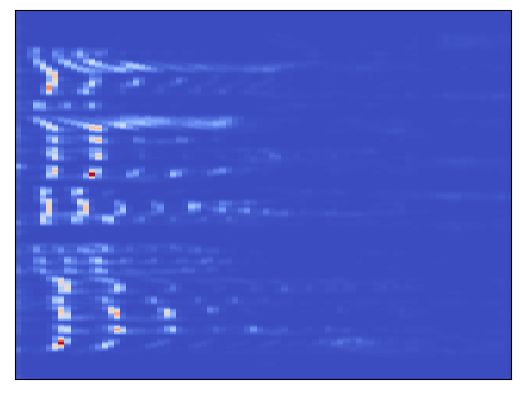

In [3]:
test = mel_spec_list[51]
librosa.display.specshow(test,sr=sr)

In [4]:
gen_wav = librosa.feature.inverse.mel_to_audio(M=test.T, sr=sr, n_fft=n_fft, hop_length=frame_shift)
IPython.display.display(Audio(gen_wav, rate=sr))

In [6]:
from nnmnkwii.io import hts

text = "おはようございます"
labels = pyopenjtalk.extract_fullcontext(text)
# フルコンテキストから、韻律記号付き音素列に変換
PP = pp_symbols(labels)

in_feats = np.array(text_to_sequence(PP), dtype=np.int64)
print(in_feats)

[ 1 35  6 25 14 48 35 35 23 35 49 14 27 31 14  7 40 45  2]


In [7]:

embeded_phoneme_list = []

with open(text_path, encoding="utf-8") as f:
    for line in f:
        wav_id, text = line.split(":")
        labels = pyopenjtalk.extract_fullcontext(text)
        # フルコンテキストから、韻律記号付き音素列に変換
        PP = pp_symbols(labels)

        in_feats = np.array(text_to_sequence(PP), dtype=np.int64)
        embeded_phoneme_list.append(np.array(in_feats))
print(len(embeded_phoneme_list))        

5000


In [8]:
from util import pad_1d, pad_2d

def ensure_divisible_by(feats, N):
    if N == 1:
        return feats
    mod = len(feats) % N
    if mod != 0:
        feats = feats[: len(feats) - mod]
    return feats

def collate_fn_tacotron(batch, reduction_factor=1):
    xs = [x[0] for x in batch]
    ys = [ensure_divisible_by(x[1], reduction_factor) for x in batch]
    in_lens = [len(x) for x in xs]
    out_lens = [len(y) for y in ys]
    in_max_len = max(in_lens)
    out_max_len = max(out_lens)
    x_batch = torch.stack([torch.from_numpy(pad_1d(x, in_max_len)) for x in xs])
    y_batch = torch.stack([torch.from_numpy(pad_2d(y, out_max_len)) for y in ys])
    in_lens = torch.tensor(in_lens, dtype=torch.long)
    out_lens = torch.tensor(out_lens, dtype=torch.long)
    stop_flags = torch.zeros(y_batch.shape[0], y_batch.shape[1])
    for idx, out_len in enumerate(out_lens):
        stop_flags[idx, out_len - 1 :] = 1.0
    return x_batch, in_lens, y_batch, out_lens, stop_flags

In [9]:
import torch
import torch.utils.data as data

class Dataset(data.Dataset):
    def __init__(self, X, y):
        self.uids = X
        self.streams = y

    def __len__(self):
        return len(self.uids)

    def __getitem__(self, idx):
        uid, stream = self.uids[idx], self.streams[idx]
        return uid, stream

In [10]:
X = mel_spec_list
y = embeded_phoneme_list
dataset = Dataset(y[:-10], X[:-10])
test_dataset = Dataset(y[-10:], X[-10:])

In [14]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, collate_fn=collate_fn_tacotron, num_workers=0)

In [15]:
from tacotron import Tacotron2 
from torch import optim

model = Tacotron2()

optimizer = optim.Adam(model.parameters(), lr=0.001)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=100000)

In [ ]:
from util import make_non_pad_mask
from torch import nn


for in_feats, in_lens, out_feats, out_lens, stop_flags in tqdm(dataloader):
    in_lens, indices = torch.sort(in_lens, dim=0, descending=True)
    in_feats, out_feats, out_lens = in_feats[indices], out_feats[indices], out_lens[indices]

    # 順伝搬の計算
    outs, outs_fine, logits, _ = model(in_feats, in_lens, out_feats)

    # ゼロパディグした部分を損失関数のの計算から除外するためにマスクを適用します
    # Mask (B x T x 1)
    mask = make_non_pad_mask(out_lens).unsqueeze(-1)
    out_feats = out_feats.masked_select(mask)
    outs = outs.masked_select(mask)
    outs_fine = outs_fine.masked_select(mask)
    stop_flags = stop_flags.masked_select(mask.squeeze(-1))
    logits = logits.masked_select(mask.squeeze(-1))

    # 損失の計算
    decoder_out_loss = nn.MSELoss()(outs, out_feats)
    postnet_out_loss = nn.MSELoss()(outs_fine, out_feats)
    stop_token_loss = nn.BCEWithLogitsLoss()(logits, stop_flags)
    # 損失の合計
    loss = decoder_out_loss + postnet_out_loss + stop_token_loss

    # 損失の値を出力
    print(f"decoder_out_loss: {decoder_out_loss:.2f}, postnet_out_loss: {postnet_out_loss:.2f}, stop_token_loss: {stop_token_loss:.2f}")
    # optimizer に蓄積された勾配をリセット
    optimizer.zero_grad()
    # 誤差の逆伝播
    loss.backward()
    # パラメータの更新
    optimizer.step()
    # 学習率スケジューラの更新
    lr_scheduler.step()


  0%|                                                                                          | 0/624 [00:00<?, ?it/s]

decoder_out_loss: 1.00, postnet_out_loss: 3.01, stop_token_loss: 0.69


  0%|▏                                                                               | 1/624 [00:36<6:19:38, 36.56s/it]

decoder_out_loss: 0.97, postnet_out_loss: 2.94, stop_token_loss: 0.48


  0%|▎                                                                               | 2/624 [01:05<5:29:56, 31.83s/it]

decoder_out_loss: 0.93, postnet_out_loss: 2.70, stop_token_loss: 0.49


  0%|▍                                                                               | 3/624 [01:54<6:50:18, 39.64s/it]

decoder_out_loss: 0.89, postnet_out_loss: 2.43, stop_token_loss: 0.31


  1%|▌                                                                               | 4/624 [02:30<6:37:00, 38.42s/it]

decoder_out_loss: 0.90, postnet_out_loss: 2.91, stop_token_loss: 0.97


  1%|▋                                                                               | 5/624 [03:46<8:57:15, 52.08s/it]

decoder_out_loss: 0.89, postnet_out_loss: 2.04, stop_token_loss: 0.43


  1%|▊                                                                               | 6/624 [04:27<8:15:28, 48.10s/it]

decoder_out_loss: 0.92, postnet_out_loss: 1.76, stop_token_loss: 0.39


  1%|▉                                                                               | 7/624 [05:12<8:06:41, 47.33s/it]

decoder_out_loss: 0.94, postnet_out_loss: 1.61, stop_token_loss: 0.43


  1%|█                                                                               | 8/624 [05:47<7:23:45, 43.22s/it]

decoder_out_loss: 0.97, postnet_out_loss: 1.96, stop_token_loss: 0.44


  1%|█▏                                                                              | 9/624 [06:47<8:17:00, 48.49s/it]

decoder_out_loss: 1.04, postnet_out_loss: 3.34, stop_token_loss: 0.39


  2%|█▎                                                                             | 10/624 [07:34<8:12:07, 48.09s/it]

decoder_out_loss: 0.99, postnet_out_loss: 1.61, stop_token_loss: 0.48


  2%|█▍                                                                             | 11/624 [08:30<8:34:31, 50.36s/it]

decoder_out_loss: 0.98, postnet_out_loss: 1.38, stop_token_loss: 0.33


  2%|█▌                                                                             | 12/624 [09:09<8:00:04, 47.07s/it]

decoder_out_loss: 0.96, postnet_out_loss: 1.55, stop_token_loss: 0.35


  2%|█▋                                                                             | 13/624 [09:43<7:18:38, 43.07s/it]

decoder_out_loss: 0.94, postnet_out_loss: 1.38, stop_token_loss: 0.33


  2%|█▊                                                                             | 14/624 [10:20<6:58:30, 41.16s/it]

decoder_out_loss: 0.94, postnet_out_loss: 1.24, stop_token_loss: 0.36


  2%|█▉                                                                             | 15/624 [10:58<6:47:46, 40.17s/it]

decoder_out_loss: 0.94, postnet_out_loss: 1.29, stop_token_loss: 0.40


  3%|██                                                                             | 16/624 [11:39<6:50:31, 40.51s/it]

decoder_out_loss: 0.93, postnet_out_loss: 1.34, stop_token_loss: 0.41


  3%|██▏                                                                            | 17/624 [12:20<6:52:40, 40.79s/it]

decoder_out_loss: 0.92, postnet_out_loss: 1.20, stop_token_loss: 0.40


  3%|██▎                                                                            | 18/624 [12:55<6:32:08, 38.83s/it]

decoder_out_loss: 0.93, postnet_out_loss: 1.74, stop_token_loss: 0.52


  3%|██▍                                                                            | 19/624 [13:40<6:52:14, 40.88s/it]

decoder_out_loss: 0.92, postnet_out_loss: 1.10, stop_token_loss: 0.29


  3%|██▌                                                                            | 20/624 [14:08<6:12:41, 37.02s/it]

decoder_out_loss: 0.92, postnet_out_loss: 1.11, stop_token_loss: 0.25


  3%|██▋                                                                            | 21/624 [14:45<6:11:46, 36.99s/it]

decoder_out_loss: 0.93, postnet_out_loss: 1.45, stop_token_loss: 0.41


  4%|██▊                                                                            | 22/624 [15:25<6:18:27, 37.72s/it]

decoder_out_loss: 0.94, postnet_out_loss: 1.26, stop_token_loss: 0.22


  4%|██▉                                                                            | 23/624 [16:00<6:11:31, 37.09s/it]

decoder_out_loss: 0.93, postnet_out_loss: 1.64, stop_token_loss: 0.53


  4%|███                                                                            | 24/624 [16:52<6:54:31, 41.45s/it]

decoder_out_loss: 0.93, postnet_out_loss: 1.12, stop_token_loss: 0.20


  4%|███▏                                                                           | 25/624 [17:14<5:54:37, 35.52s/it]

decoder_out_loss: 0.91, postnet_out_loss: 1.14, stop_token_loss: 0.30


  4%|███▎                                                                           | 26/624 [17:48<5:50:39, 35.18s/it]

decoder_out_loss: 0.91, postnet_out_loss: 1.58, stop_token_loss: 0.44


  4%|███▍                                                                           | 27/624 [18:38<6:33:42, 39.57s/it]

decoder_out_loss: 0.91, postnet_out_loss: 1.04, stop_token_loss: 0.19


  4%|███▌                                                                           | 28/624 [19:05<5:55:50, 35.82s/it]

decoder_out_loss: 0.91, postnet_out_loss: 2.02, stop_token_loss: 0.15


  5%|███▋                                                                           | 29/624 [19:33<5:31:00, 33.38s/it]

decoder_out_loss: 0.88, postnet_out_loss: 1.67, stop_token_loss: 0.56


  5%|███▊                                                                           | 30/624 [20:24<6:23:57, 38.78s/it]

decoder_out_loss: 0.90, postnet_out_loss: 1.25, stop_token_loss: 0.29


  5%|███▉                                                                           | 31/624 [20:54<5:56:39, 36.09s/it]

decoder_out_loss: 0.90, postnet_out_loss: 1.11, stop_token_loss: 0.27


  5%|████                                                                           | 32/624 [21:25<5:41:19, 34.59s/it]

decoder_out_loss: 0.88, postnet_out_loss: 1.50, stop_token_loss: 0.47


  5%|████▏                                                                          | 33/624 [21:57<5:33:05, 33.82s/it]

decoder_out_loss: 0.87, postnet_out_loss: 2.13, stop_token_loss: 0.58


  5%|████▎                                                                          | 34/624 [22:59<6:54:22, 42.14s/it]

decoder_out_loss: 0.87, postnet_out_loss: 1.20, stop_token_loss: 0.17


  6%|████▍                                                                          | 35/624 [23:46<7:10:40, 43.87s/it]

decoder_out_loss: 0.89, postnet_out_loss: 1.30, stop_token_loss: 0.47


  6%|████▌                                                                          | 36/624 [24:29<7:05:27, 43.41s/it]

decoder_out_loss: 0.89, postnet_out_loss: 1.40, stop_token_loss: 0.45


  6%|████▋                                                                          | 37/624 [25:21<7:30:02, 46.00s/it]

decoder_out_loss: 0.91, postnet_out_loss: 1.13, stop_token_loss: 0.40


  6%|████▊                                                                          | 38/624 [25:55<6:55:07, 42.50s/it]

decoder_out_loss: 0.91, postnet_out_loss: 2.07, stop_token_loss: 0.28


  6%|████▉                                                                          | 39/624 [27:03<8:09:45, 50.23s/it]

decoder_out_loss: 0.91, postnet_out_loss: 1.40, stop_token_loss: 0.51


  6%|█████                                                                          | 40/624 [27:52<8:03:35, 49.68s/it]

decoder_out_loss: 0.92, postnet_out_loss: 1.03, stop_token_loss: 0.30


  7%|█████▏                                                                         | 41/624 [28:24<7:12:47, 44.54s/it]

decoder_out_loss: 0.90, postnet_out_loss: 1.06, stop_token_loss: 0.35


  7%|█████▎                                                                         | 42/624 [29:04<6:56:45, 42.96s/it]

decoder_out_loss: 0.90, postnet_out_loss: 1.60, stop_token_loss: 0.24


  7%|█████▍                                                                         | 43/624 [30:01<7:38:35, 47.36s/it]

decoder_out_loss: 0.90, postnet_out_loss: 1.48, stop_token_loss: 0.38


  7%|█████▌                                                                         | 44/624 [30:53<7:49:41, 48.59s/it]

decoder_out_loss: 0.88, postnet_out_loss: 1.67, stop_token_loss: 0.31


  7%|█████▋                                                                         | 45/624 [31:27<7:06:24, 44.19s/it]

decoder_out_loss: 0.90, postnet_out_loss: 1.18, stop_token_loss: 0.33


  7%|█████▊                                                                         | 46/624 [32:04<6:45:57, 42.14s/it]

decoder_out_loss: 0.90, postnet_out_loss: 1.39, stop_token_loss: 0.33


  8%|█████▉                                                                         | 47/624 [33:09<7:51:01, 48.98s/it]

decoder_out_loss: 0.89, postnet_out_loss: 1.14, stop_token_loss: 0.32


  8%|██████                                                                         | 48/624 [33:43<7:08:32, 44.64s/it]

decoder_out_loss: 0.90, postnet_out_loss: 1.65, stop_token_loss: 0.43


  8%|██████▏                                                                        | 49/624 [34:35<7:26:24, 46.58s/it]

decoder_out_loss: 0.89, postnet_out_loss: 1.42, stop_token_loss: 0.28


  8%|██████▎                                                                        | 50/624 [35:05<6:39:29, 41.76s/it]

decoder_out_loss: 0.86, postnet_out_loss: 1.22, stop_token_loss: 0.24


  8%|██████▍                                                                        | 51/624 [35:48<6:42:45, 42.17s/it]

decoder_out_loss: 0.85, postnet_out_loss: 1.63, stop_token_loss: 0.47


  8%|██████▌                                                                        | 52/624 [36:42<7:16:19, 45.77s/it]

decoder_out_loss: 0.85, postnet_out_loss: 1.48, stop_token_loss: 0.43


  8%|██████▋                                                                        | 53/624 [37:28<7:16:04, 45.82s/it]

decoder_out_loss: 0.84, postnet_out_loss: 1.10, stop_token_loss: 0.27


  9%|██████▊                                                                        | 54/624 [38:02<6:41:10, 42.23s/it]

decoder_out_loss: 0.80, postnet_out_loss: 1.42, stop_token_loss: 0.44


  9%|██████▉                                                                        | 55/624 [38:45<6:43:10, 42.51s/it]

decoder_out_loss: 0.83, postnet_out_loss: 1.60, stop_token_loss: 0.45


  9%|███████                                                                        | 56/624 [39:29<6:46:37, 42.95s/it]

decoder_out_loss: 0.87, postnet_out_loss: 1.68, stop_token_loss: 0.22


  9%|███████▏                                                                       | 57/624 [39:55<5:58:02, 37.89s/it]

decoder_out_loss: 0.84, postnet_out_loss: 1.26, stop_token_loss: 0.35


  9%|███████▎                                                                       | 58/624 [40:41<6:19:54, 40.27s/it]

decoder_out_loss: 0.83, postnet_out_loss: 1.68, stop_token_loss: 0.39


  9%|███████▍                                                                       | 59/624 [41:50<7:39:34, 48.80s/it]

decoder_out_loss: 0.85, postnet_out_loss: 1.03, stop_token_loss: 0.41


 10%|███████▌                                                                       | 60/624 [42:28<7:07:04, 45.43s/it]

decoder_out_loss: 0.83, postnet_out_loss: 1.03, stop_token_loss: 0.37


 10%|███████▋                                                                       | 61/624 [43:05<6:42:49, 42.93s/it]

decoder_out_loss: 0.80, postnet_out_loss: 1.44, stop_token_loss: 0.39


 10%|███████▊                                                                       | 62/624 [43:56<7:05:35, 45.44s/it]

decoder_out_loss: 0.84, postnet_out_loss: 1.02, stop_token_loss: 0.16


 10%|███████▉                                                                       | 63/624 [44:29<6:31:22, 41.86s/it]

decoder_out_loss: 0.78, postnet_out_loss: 1.16, stop_token_loss: 0.30


 10%|████████                                                                       | 64/624 [45:09<6:23:23, 41.08s/it]

decoder_out_loss: 0.78, postnet_out_loss: 1.10, stop_token_loss: 0.28


 10%|████████▏                                                                      | 65/624 [45:42<6:01:34, 38.81s/it]

decoder_out_loss: 0.75, postnet_out_loss: 0.95, stop_token_loss: 0.30


 11%|████████▎                                                                      | 66/624 [46:10<5:29:52, 35.47s/it]

decoder_out_loss: 0.74, postnet_out_loss: 1.12, stop_token_loss: 0.47


 11%|████████▍                                                                      | 67/624 [46:47<5:33:55, 35.97s/it]

decoder_out_loss: 0.75, postnet_out_loss: 2.74, stop_token_loss: 0.64


 11%|████████▌                                                                      | 68/624 [48:28<8:34:07, 55.48s/it]

decoder_out_loss: 0.77, postnet_out_loss: 1.06, stop_token_loss: 0.43


 11%|████████▋                                                                      | 69/624 [49:11<7:58:47, 51.76s/it]

decoder_out_loss: 0.77, postnet_out_loss: 0.97, stop_token_loss: 0.42


 11%|████████▊                                                                      | 70/624 [49:46<7:10:18, 46.60s/it]

decoder_out_loss: 0.80, postnet_out_loss: 1.23, stop_token_loss: 0.36


 11%|████████▉                                                                      | 71/624 [50:29<7:00:25, 45.62s/it]

decoder_out_loss: 0.78, postnet_out_loss: 1.76, stop_token_loss: 0.50


 12%|█████████                                                                      | 72/624 [51:43<8:17:00, 54.02s/it]

decoder_out_loss: 0.78, postnet_out_loss: 1.15, stop_token_loss: 0.37


 12%|█████████▏                                                                     | 73/624 [52:30<7:56:33, 51.89s/it]

decoder_out_loss: 0.76, postnet_out_loss: 2.08, stop_token_loss: 0.21


 12%|█████████▎                                                                     | 74/624 [53:00<6:56:38, 45.45s/it]

decoder_out_loss: 0.77, postnet_out_loss: 1.34, stop_token_loss: 0.48


 12%|█████████▍                                                                     | 75/624 [53:51<7:11:00, 47.10s/it]

decoder_out_loss: 0.75, postnet_out_loss: 1.84, stop_token_loss: 0.18


 12%|█████████▌                                                                     | 76/624 [54:22<6:27:36, 42.44s/it]

decoder_out_loss: 0.75, postnet_out_loss: 1.38, stop_token_loss: 0.31


 12%|█████████▋                                                                     | 77/624 [55:17<6:59:57, 46.06s/it]

decoder_out_loss: 0.77, postnet_out_loss: 2.48, stop_token_loss: 0.33


 12%|█████████▊                                                                    | 78/624 [57:26<10:45:15, 70.91s/it]

decoder_out_loss: 0.78, postnet_out_loss: 1.04, stop_token_loss: 0.30


 13%|██████████                                                                     | 79/624 [58:10<9:32:05, 62.98s/it]

decoder_out_loss: 0.79, postnet_out_loss: 0.87, stop_token_loss: 0.32


 13%|██████████▏                                                                    | 80/624 [58:42<8:06:46, 53.69s/it]

decoder_out_loss: 0.78, postnet_out_loss: 0.96, stop_token_loss: 0.49


 13%|██████████▎                                                                    | 81/624 [59:27<7:40:48, 50.92s/it]

decoder_out_loss: 0.84, postnet_out_loss: 1.23, stop_token_loss: 0.53


 13%|██████████                                                                   | 82/624 [1:00:15<7:31:46, 50.01s/it]

decoder_out_loss: 0.78, postnet_out_loss: 1.16, stop_token_loss: 0.38


 13%|██████████▏                                                                  | 83/624 [1:00:56<7:07:09, 47.37s/it]

decoder_out_loss: 0.79, postnet_out_loss: 1.03, stop_token_loss: 0.20


 13%|██████████▎                                                                  | 84/624 [1:01:38<6:51:49, 45.76s/it]

decoder_out_loss: 0.74, postnet_out_loss: 0.86, stop_token_loss: 0.25


 14%|██████████▍                                                                  | 85/624 [1:02:05<6:02:03, 40.30s/it]

decoder_out_loss: 0.74, postnet_out_loss: 1.23, stop_token_loss: 0.23


 14%|██████████▌                                                                  | 86/624 [1:02:46<6:02:20, 40.41s/it]

decoder_out_loss: 0.73, postnet_out_loss: 1.17, stop_token_loss: 0.35


 14%|██████████▋                                                                  | 87/624 [1:03:33<6:17:41, 42.20s/it]

decoder_out_loss: 0.75, postnet_out_loss: 1.25, stop_token_loss: 0.41


 14%|██████████▊                                                                  | 88/624 [1:04:38<7:18:49, 49.12s/it]

decoder_out_loss: 0.73, postnet_out_loss: 0.92, stop_token_loss: 0.45


 14%|██████████▉                                                                  | 89/624 [1:05:19<6:56:18, 46.69s/it]

decoder_out_loss: 0.73, postnet_out_loss: 1.51, stop_token_loss: 0.47


 14%|███████████                                                                  | 90/624 [1:06:13<7:14:15, 48.79s/it]

decoder_out_loss: 0.76, postnet_out_loss: 1.16, stop_token_loss: 0.56


 15%|███████████▏                                                                 | 91/624 [1:07:09<7:34:19, 51.14s/it]

decoder_out_loss: 0.71, postnet_out_loss: 0.85, stop_token_loss: 0.39


 15%|███████████▎                                                                 | 92/624 [1:07:53<7:15:23, 49.10s/it]

decoder_out_loss: 0.72, postnet_out_loss: 0.87, stop_token_loss: 0.31


 15%|███████████▍                                                                 | 93/624 [1:08:44<7:18:01, 49.49s/it]

decoder_out_loss: 0.71, postnet_out_loss: 0.85, stop_token_loss: 0.43


 15%|███████████▌                                                                 | 94/624 [1:09:37<7:26:21, 50.53s/it]

decoder_out_loss: 0.65, postnet_out_loss: 1.01, stop_token_loss: 0.30


 15%|███████████▋                                                                 | 95/624 [1:10:08<6:33:40, 44.65s/it]

decoder_out_loss: 0.65, postnet_out_loss: 1.19, stop_token_loss: 0.37


 15%|███████████▊                                                                 | 96/624 [1:10:40<6:00:01, 40.91s/it]

decoder_out_loss: 0.64, postnet_out_loss: 0.84, stop_token_loss: 0.33


 16%|███████████▉                                                                 | 97/624 [1:11:21<5:59:14, 40.90s/it]

decoder_out_loss: 0.68, postnet_out_loss: 0.92, stop_token_loss: 0.26


 16%|████████████                                                                 | 98/624 [1:11:47<5:20:46, 36.59s/it]

decoder_out_loss: 0.68, postnet_out_loss: 0.91, stop_token_loss: 0.56


 16%|████████████▏                                                                | 99/624 [1:12:35<5:48:01, 39.77s/it]

decoder_out_loss: 0.70, postnet_out_loss: 1.11, stop_token_loss: 0.47


 16%|████████████▏                                                               | 100/624 [1:13:21<6:04:36, 41.75s/it]

decoder_out_loss: 1.74, postnet_out_loss: 1.97, stop_token_loss: 0.37


 16%|████████████▎                                                               | 101/624 [1:13:52<5:35:24, 38.48s/it]

decoder_out_loss: 0.74, postnet_out_loss: 0.93, stop_token_loss: 0.41


 16%|████████████▍                                                               | 102/624 [1:14:41<6:02:14, 41.64s/it]

decoder_out_loss: 0.69, postnet_out_loss: 2.08, stop_token_loss: 0.30


 17%|████████████▌                                                               | 103/624 [1:15:03<5:12:12, 35.96s/it]

decoder_out_loss: 0.76, postnet_out_loss: 1.69, stop_token_loss: 0.48


 17%|████████████▋                                                               | 104/624 [1:15:52<5:44:06, 39.71s/it]

decoder_out_loss: 0.74, postnet_out_loss: 1.96, stop_token_loss: 0.38


 17%|████████████▊                                                               | 105/624 [1:16:32<5:43:33, 39.72s/it]

decoder_out_loss: 0.75, postnet_out_loss: 1.54, stop_token_loss: 0.35


 17%|████████████▉                                                               | 106/624 [1:17:05<5:25:43, 37.73s/it]

decoder_out_loss: 0.73, postnet_out_loss: 1.69, stop_token_loss: 0.33


 17%|█████████████                                                               | 107/624 [1:17:37<5:11:44, 36.18s/it]

decoder_out_loss: 0.77, postnet_out_loss: 1.63, stop_token_loss: 0.46


 17%|█████████████▏                                                              | 108/624 [1:18:46<6:34:47, 45.91s/it]

decoder_out_loss: 0.75, postnet_out_loss: 1.04, stop_token_loss: 0.27


 17%|█████████████▎                                                              | 109/624 [1:19:16<5:53:55, 41.23s/it]

decoder_out_loss: 0.75, postnet_out_loss: 1.14, stop_token_loss: 0.47


 18%|█████████████▍                                                              | 110/624 [1:19:57<5:51:53, 41.08s/it]

decoder_out_loss: 0.74, postnet_out_loss: 1.20, stop_token_loss: 0.73


 18%|█████████████▌                                                              | 111/624 [1:21:07<7:04:14, 49.62s/it]

decoder_out_loss: 0.71, postnet_out_loss: 1.00, stop_token_loss: 0.36


 18%|█████████████▋                                                              | 112/624 [1:21:45<6:34:33, 46.24s/it]

decoder_out_loss: 0.75, postnet_out_loss: 1.02, stop_token_loss: 0.37


 18%|█████████████▊                                                              | 113/624 [1:22:23<6:13:06, 43.81s/it]

decoder_out_loss: 0.73, postnet_out_loss: 1.17, stop_token_loss: 0.40


 18%|█████████████▉                                                              | 114/624 [1:23:06<6:09:35, 43.48s/it]

decoder_out_loss: 0.76, postnet_out_loss: 1.01, stop_token_loss: 0.32


 18%|██████████████                                                              | 115/624 [1:23:40<5:46:34, 40.85s/it]

decoder_out_loss: 0.73, postnet_out_loss: 1.02, stop_token_loss: 0.25


 19%|██████████████▏                                                             | 116/624 [1:24:19<5:40:13, 40.18s/it]

decoder_out_loss: 0.73, postnet_out_loss: 1.52, stop_token_loss: 0.53


 19%|██████████████▎                                                             | 117/624 [1:25:34<7:08:06, 50.66s/it]

decoder_out_loss: 0.79, postnet_out_loss: 0.90, stop_token_loss: 0.32


 19%|██████████████▎                                                             | 118/624 [1:26:14<6:39:48, 47.41s/it]

decoder_out_loss: 0.74, postnet_out_loss: 2.11, stop_token_loss: 0.80


 19%|██████████████▍                                                             | 119/624 [1:27:55<8:54:31, 63.51s/it]

decoder_out_loss: 0.77, postnet_out_loss: 1.23, stop_token_loss: 0.60


 19%|██████████████▌                                                             | 120/624 [1:28:54<8:42:47, 62.24s/it]

decoder_out_loss: 0.77, postnet_out_loss: 1.60, stop_token_loss: 0.48


 19%|██████████████▋                                                             | 121/624 [1:30:14<9:25:40, 67.48s/it]

decoder_out_loss: 0.78, postnet_out_loss: 1.09, stop_token_loss: 0.36


 20%|██████████████▊                                                             | 122/624 [1:30:59<8:28:20, 60.76s/it]

decoder_out_loss: 0.77, postnet_out_loss: 2.08, stop_token_loss: 0.22


 20%|██████████████▉                                                             | 123/624 [1:31:27<7:05:08, 50.91s/it]

decoder_out_loss: 0.73, postnet_out_loss: 1.25, stop_token_loss: 0.31


 20%|███████████████                                                             | 124/624 [1:32:01<6:22:33, 45.91s/it]

decoder_out_loss: 0.70, postnet_out_loss: 0.92, stop_token_loss: 0.28


 20%|███████████████▏                                                            | 125/624 [1:32:44<6:13:27, 44.90s/it]

decoder_out_loss: 0.72, postnet_out_loss: 1.69, stop_token_loss: 0.57


 20%|███████████████▎                                                            | 126/624 [1:34:23<8:27:08, 61.10s/it]

decoder_out_loss: 0.69, postnet_out_loss: 1.22, stop_token_loss: 0.56


 20%|███████████████▍                                                            | 127/624 [1:35:08<7:46:12, 56.28s/it]

decoder_out_loss: 0.71, postnet_out_loss: 1.21, stop_token_loss: 0.41


 21%|███████████████▌                                                            | 128/624 [1:36:06<7:49:09, 56.75s/it]

decoder_out_loss: 0.73, postnet_out_loss: 1.51, stop_token_loss: 0.53


 21%|███████████████▋                                                            | 129/624 [1:37:06<7:57:32, 57.88s/it]

decoder_out_loss: 0.74, postnet_out_loss: 1.00, stop_token_loss: 0.37


 21%|███████████████▊                                                            | 130/624 [1:37:49<7:19:44, 53.41s/it]

decoder_out_loss: 0.75, postnet_out_loss: 1.56, stop_token_loss: 0.33


 21%|███████████████▉                                                            | 131/624 [1:38:27<6:40:59, 48.80s/it]

decoder_out_loss: 0.75, postnet_out_loss: 1.30, stop_token_loss: 0.41


 21%|████████████████                                                            | 132/624 [1:39:32<7:19:27, 53.59s/it]

decoder_out_loss: 0.74, postnet_out_loss: 0.87, stop_token_loss: 0.27


 21%|████████████████▏                                                           | 133/624 [1:40:04<6:25:56, 47.16s/it]

decoder_out_loss: 0.70, postnet_out_loss: 0.84, stop_token_loss: 0.36


 21%|████████████████▎                                                           | 134/624 [1:40:44<6:06:20, 44.86s/it]

decoder_out_loss: 0.69, postnet_out_loss: 0.80, stop_token_loss: 0.35


 22%|████████████████▍                                                           | 135/624 [1:41:28<6:05:12, 44.81s/it]

decoder_out_loss: 0.65, postnet_out_loss: 1.02, stop_token_loss: 0.52


 22%|████████████████▌                                                           | 136/624 [1:42:27<6:37:46, 48.91s/it]

decoder_out_loss: 0.62, postnet_out_loss: 0.80, stop_token_loss: 0.43


 22%|████████████████▋                                                           | 137/624 [1:43:18<6:41:44, 49.50s/it]

decoder_out_loss: 0.68, postnet_out_loss: 0.81, stop_token_loss: 0.35


 22%|████████████████▊                                                           | 138/624 [1:43:58<6:19:10, 46.81s/it]

decoder_out_loss: 0.64, postnet_out_loss: 1.53, stop_token_loss: 0.48


 22%|████████████████▉                                                           | 139/624 [1:45:14<7:27:36, 55.37s/it]

decoder_out_loss: 0.66, postnet_out_loss: 1.01, stop_token_loss: 0.57


 22%|█████████████████                                                           | 140/624 [1:46:32<8:22:22, 62.28s/it]

decoder_out_loss: 0.62, postnet_out_loss: 0.90, stop_token_loss: 0.43


 23%|█████████████████▏                                                          | 141/624 [1:47:22<7:50:51, 58.49s/it]

decoder_out_loss: 0.66, postnet_out_loss: 1.15, stop_token_loss: 0.53


 23%|█████████████████▎                                                          | 142/624 [1:48:30<8:14:48, 61.60s/it]

decoder_out_loss: 0.66, postnet_out_loss: 0.80, stop_token_loss: 0.45


 23%|█████████████████▍                                                          | 143/624 [1:49:15<7:33:40, 56.59s/it]

decoder_out_loss: 0.66, postnet_out_loss: 0.78, stop_token_loss: 0.30


 23%|█████████████████▌                                                          | 144/624 [1:50:05<7:16:51, 54.61s/it]

decoder_out_loss: 0.64, postnet_out_loss: 0.76, stop_token_loss: 0.27


 23%|█████████████████▋                                                          | 145/624 [1:50:37<6:20:08, 47.62s/it]

decoder_out_loss: 0.64, postnet_out_loss: 1.02, stop_token_loss: 0.43


 23%|█████████████████▊                                                          | 146/624 [1:51:31<6:35:26, 49.64s/it]

decoder_out_loss: 0.61, postnet_out_loss: 1.12, stop_token_loss: 0.33


 24%|█████████████████▉                                                          | 147/624 [1:52:34<7:06:00, 53.59s/it]

decoder_out_loss: 0.64, postnet_out_loss: 0.74, stop_token_loss: 0.27


 24%|██████████████████                                                          | 148/624 [1:53:09<6:22:26, 48.21s/it]

decoder_out_loss: 0.61, postnet_out_loss: 0.82, stop_token_loss: 0.36


 24%|██████████████████▏                                                         | 149/624 [1:53:52<6:07:20, 46.40s/it]

decoder_out_loss: 0.64, postnet_out_loss: 0.75, stop_token_loss: 0.21


 24%|██████████████████▎                                                         | 150/624 [1:54:23<5:31:58, 42.02s/it]

decoder_out_loss: 0.55, postnet_out_loss: 1.77, stop_token_loss: 0.23


 24%|██████████████████▍                                                         | 151/624 [1:54:51<4:58:17, 37.84s/it]

decoder_out_loss: 0.58, postnet_out_loss: 1.09, stop_token_loss: 0.41


 24%|██████████████████▌                                                         | 152/624 [1:55:44<5:31:37, 42.16s/it]

decoder_out_loss: 0.60, postnet_out_loss: 1.15, stop_token_loss: 0.33


 25%|██████████████████▋                                                         | 153/624 [1:56:43<6:11:44, 47.35s/it]

decoder_out_loss: 0.58, postnet_out_loss: 0.67, stop_token_loss: 0.31


 25%|██████████████████▊                                                         | 154/624 [1:57:21<5:48:27, 44.48s/it]

decoder_out_loss: 0.61, postnet_out_loss: 1.00, stop_token_loss: 0.38


 25%|██████████████████▉                                                         | 155/624 [1:58:05<5:46:01, 44.27s/it]

decoder_out_loss: 0.63, postnet_out_loss: 0.73, stop_token_loss: 0.29


 25%|███████████████████                                                         | 156/624 [1:58:46<5:39:01, 43.47s/it]

decoder_out_loss: 0.60, postnet_out_loss: 0.90, stop_token_loss: 0.55


 25%|███████████████████                                                         | 157/624 [1:59:30<5:37:51, 43.41s/it]

decoder_out_loss: 0.60, postnet_out_loss: 0.76, stop_token_loss: 0.43


 25%|███████████████████▏                                                        | 158/624 [2:00:10<5:30:47, 42.59s/it]

decoder_out_loss: 0.57, postnet_out_loss: 1.12, stop_token_loss: 0.44


 25%|███████████████████▎                                                        | 159/624 [2:01:28<6:52:32, 53.23s/it]

decoder_out_loss: 0.56, postnet_out_loss: 0.64, stop_token_loss: 0.25


 26%|███████████████████▍                                                        | 160/624 [2:02:07<6:17:09, 48.77s/it]

decoder_out_loss: 0.58, postnet_out_loss: 0.65, stop_token_loss: 0.36


 26%|███████████████████▌                                                        | 161/624 [2:02:41<5:43:38, 44.53s/it]

decoder_out_loss: 0.55, postnet_out_loss: 0.62, stop_token_loss: 0.31


 26%|███████████████████▋                                                        | 162/624 [2:03:25<5:39:45, 44.12s/it]

decoder_out_loss: 0.55, postnet_out_loss: 0.73, stop_token_loss: 0.53


 26%|███████████████████▊                                                        | 163/624 [2:04:11<5:45:03, 44.91s/it]

decoder_out_loss: 0.55, postnet_out_loss: 0.76, stop_token_loss: 0.30


 26%|███████████████████▉                                                        | 164/624 [2:04:58<5:48:27, 45.45s/it]

decoder_out_loss: 0.54, postnet_out_loss: 0.71, stop_token_loss: 0.26


 26%|████████████████████                                                        | 165/624 [2:05:33<5:23:17, 42.26s/it]

decoder_out_loss: 0.52, postnet_out_loss: 0.67, stop_token_loss: 0.29


 27%|████████████████████▏                                                       | 166/624 [2:06:07<5:03:41, 39.78s/it]

decoder_out_loss: 0.54, postnet_out_loss: 0.64, stop_token_loss: 0.28


 27%|████████████████████▎                                                       | 167/624 [2:06:38<4:42:12, 37.05s/it]

decoder_out_loss: 0.53, postnet_out_loss: 0.78, stop_token_loss: 0.30


 27%|████████████████████▍                                                       | 168/624 [2:07:21<4:55:36, 38.90s/it]

decoder_out_loss: 0.53, postnet_out_loss: 0.66, stop_token_loss: 0.19


 27%|████████████████████▌                                                       | 169/624 [2:07:59<4:52:47, 38.61s/it]

decoder_out_loss: 0.52, postnet_out_loss: 1.41, stop_token_loss: 0.60


 27%|████████████████████▋                                                       | 170/624 [2:09:08<6:02:14, 47.87s/it]

decoder_out_loss: 0.54, postnet_out_loss: 0.67, stop_token_loss: 0.37


 27%|████████████████████▊                                                       | 171/624 [2:09:46<5:38:06, 44.78s/it]

decoder_out_loss: 0.55, postnet_out_loss: 0.74, stop_token_loss: 0.37


 28%|████████████████████▉                                                       | 172/624 [2:10:40<5:58:26, 47.58s/it]

decoder_out_loss: 0.57, postnet_out_loss: 0.99, stop_token_loss: 0.37


 28%|█████████████████████                                                       | 173/624 [2:11:31<6:05:19, 48.60s/it]

decoder_out_loss: 0.54, postnet_out_loss: 1.03, stop_token_loss: 0.23


 28%|█████████████████████▏                                                      | 174/624 [2:12:04<5:29:30, 43.94s/it]

decoder_out_loss: 0.56, postnet_out_loss: 0.74, stop_token_loss: 0.29


 28%|█████████████████████▎                                                      | 175/624 [2:13:00<5:55:12, 47.47s/it]

decoder_out_loss: 0.54, postnet_out_loss: 1.29, stop_token_loss: 0.63


 28%|█████████████████████▍                                                      | 176/624 [2:14:19<7:05:32, 56.99s/it]

decoder_out_loss: 0.51, postnet_out_loss: 0.76, stop_token_loss: 0.45


 28%|█████████████████████▌                                                      | 177/624 [2:15:10<6:52:04, 55.31s/it]

decoder_out_loss: 0.52, postnet_out_loss: 0.63, stop_token_loss: 0.32


 29%|█████████████████████▋                                                      | 178/624 [2:15:53<6:23:56, 51.65s/it]

decoder_out_loss: 0.56, postnet_out_loss: 1.01, stop_token_loss: 0.66


 29%|█████████████████████▊                                                      | 179/624 [2:16:53<6:40:31, 54.00s/it]

decoder_out_loss: 0.52, postnet_out_loss: 0.64, stop_token_loss: 0.42


 29%|█████████████████████▉                                                      | 180/624 [2:17:32<6:07:01, 49.60s/it]

decoder_out_loss: 0.53, postnet_out_loss: 0.59, stop_token_loss: 0.28


 29%|██████████████████████                                                      | 181/624 [2:18:08<5:36:12, 45.54s/it]

decoder_out_loss: 0.50, postnet_out_loss: 0.55, stop_token_loss: 0.30


 29%|██████████████████████▏                                                     | 182/624 [2:18:47<5:20:14, 43.47s/it]

decoder_out_loss: 0.48, postnet_out_loss: 0.54, stop_token_loss: 0.34


 29%|██████████████████████▎                                                     | 183/624 [2:19:20<4:56:45, 40.38s/it]

decoder_out_loss: 0.49, postnet_out_loss: 0.89, stop_token_loss: 0.44


 29%|██████████████████████▍                                                     | 184/624 [2:20:19<5:36:51, 45.94s/it]

decoder_out_loss: 0.47, postnet_out_loss: 0.59, stop_token_loss: 0.42


 30%|██████████████████████▌                                                     | 185/624 [2:20:57<5:19:41, 43.69s/it]

decoder_out_loss: 0.48, postnet_out_loss: 0.87, stop_token_loss: 0.58


 30%|██████████████████████▋                                                     | 186/624 [2:21:56<5:52:46, 48.33s/it]

decoder_out_loss: 0.49, postnet_out_loss: 0.69, stop_token_loss: 0.50


 30%|██████████████████████▊                                                     | 187/624 [2:22:37<5:35:40, 46.09s/it]

decoder_out_loss: 0.47, postnet_out_loss: 0.54, stop_token_loss: 0.26


 30%|██████████████████████▉                                                     | 188/624 [2:23:08<5:02:17, 41.60s/it]

decoder_out_loss: 0.48, postnet_out_loss: 0.85, stop_token_loss: 0.36


 30%|███████████████████████                                                     | 189/624 [2:24:08<5:41:31, 47.11s/it]

decoder_out_loss: 0.44, postnet_out_loss: 0.77, stop_token_loss: 0.35


 30%|███████████████████████▏                                                    | 190/624 [2:24:34<4:53:02, 40.51s/it]

decoder_out_loss: 0.46, postnet_out_loss: 0.51, stop_token_loss: 0.28


 31%|███████████████████████▎                                                    | 191/624 [2:25:12<4:48:02, 39.91s/it]

decoder_out_loss: 0.47, postnet_out_loss: 0.61, stop_token_loss: 0.28


 31%|███████████████████████▍                                                    | 192/624 [2:25:48<4:38:30, 38.68s/it]

decoder_out_loss: 0.43, postnet_out_loss: 0.51, stop_token_loss: 0.21


 31%|███████████████████████▌                                                    | 193/624 [2:26:19<4:22:01, 36.48s/it]

decoder_out_loss: 0.45, postnet_out_loss: 0.60, stop_token_loss: 0.39


 31%|███████████████████████▋                                                    | 194/624 [2:26:58<4:25:27, 37.04s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.72, stop_token_loss: 0.54


 31%|███████████████████████▊                                                    | 195/624 [2:27:47<4:51:56, 40.83s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.50, stop_token_loss: 0.24


 31%|███████████████████████▊                                                    | 196/624 [2:28:21<4:35:41, 38.65s/it]

decoder_out_loss: 0.45, postnet_out_loss: 0.69, stop_token_loss: 0.28


 32%|███████████████████████▉                                                    | 197/624 [2:29:02<4:40:24, 39.40s/it]

decoder_out_loss: 0.45, postnet_out_loss: 0.82, stop_token_loss: 0.48


 32%|████████████████████████                                                    | 198/624 [2:30:03<5:25:55, 45.90s/it]

decoder_out_loss: 0.48, postnet_out_loss: 0.92, stop_token_loss: 0.52


 32%|████████████████████████▏                                                   | 199/624 [2:30:52<5:32:25, 46.93s/it]

decoder_out_loss: 0.47, postnet_out_loss: 1.10, stop_token_loss: 0.68


 32%|████████████████████████▎                                                   | 200/624 [2:31:59<6:13:59, 52.92s/it]

decoder_out_loss: 0.50, postnet_out_loss: 0.53, stop_token_loss: 0.29


 32%|████████████████████████▍                                                   | 201/624 [2:32:29<5:23:05, 45.83s/it]

decoder_out_loss: 0.48, postnet_out_loss: 0.51, stop_token_loss: 0.35


 32%|████████████████████████▌                                                   | 202/624 [2:33:00<4:52:03, 41.52s/it]

decoder_out_loss: 0.48, postnet_out_loss: 0.79, stop_token_loss: 0.65


 33%|████████████████████████▋                                                   | 203/624 [2:34:14<6:00:27, 51.37s/it]

decoder_out_loss: 0.49, postnet_out_loss: 0.73, stop_token_loss: 0.26


 33%|████████████████████████▊                                                   | 204/624 [2:35:01<5:49:56, 49.99s/it]

decoder_out_loss: 0.43, postnet_out_loss: 0.57, stop_token_loss: 0.24


 33%|████████████████████████▉                                                   | 205/624 [2:35:33<5:11:14, 44.57s/it]

decoder_out_loss: 0.43, postnet_out_loss: 0.46, stop_token_loss: 0.25


 33%|█████████████████████████                                                   | 206/624 [2:36:05<4:43:27, 40.69s/it]

decoder_out_loss: 0.44, postnet_out_loss: 0.58, stop_token_loss: 0.27


 33%|█████████████████████████▏                                                  | 207/624 [2:36:45<4:41:59, 40.57s/it]

decoder_out_loss: 0.45, postnet_out_loss: 0.51, stop_token_loss: 0.29


 33%|█████████████████████████▎                                                  | 208/624 [2:37:16<4:20:30, 37.57s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.45, stop_token_loss: 0.29


 33%|█████████████████████████▍                                                  | 209/624 [2:37:41<3:54:28, 33.90s/it]

decoder_out_loss: 0.44, postnet_out_loss: 0.75, stop_token_loss: 0.43


 34%|█████████████████████████▌                                                  | 210/624 [2:38:31<4:27:03, 38.70s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.50, stop_token_loss: 0.29


 34%|█████████████████████████▋                                                  | 211/624 [2:39:01<4:08:45, 36.14s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.46, stop_token_loss: 0.29


 34%|█████████████████████████▊                                                  | 212/624 [2:39:33<3:59:19, 34.85s/it]

decoder_out_loss: 0.40, postnet_out_loss: 0.87, stop_token_loss: 0.52


 34%|█████████████████████████▉                                                  | 213/624 [2:40:28<4:40:17, 40.92s/it]

decoder_out_loss: 0.40, postnet_out_loss: 0.46, stop_token_loss: 0.20


 34%|██████████████████████████                                                  | 214/624 [2:40:56<4:12:43, 36.98s/it]

decoder_out_loss: 0.40, postnet_out_loss: 0.58, stop_token_loss: 0.37


 34%|██████████████████████████▏                                                 | 215/624 [2:41:41<4:29:22, 39.52s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.44, stop_token_loss: 0.26


 35%|██████████████████████████▎                                                 | 216/624 [2:42:11<4:09:30, 36.69s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.49, stop_token_loss: 0.29


 35%|██████████████████████████▍                                                 | 217/624 [2:42:57<4:26:27, 39.28s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.57, stop_token_loss: 0.28


 35%|██████████████████████████▌                                                 | 218/624 [2:43:36<4:25:38, 39.26s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.49, stop_token_loss: 0.45


 35%|██████████████████████████▋                                                 | 219/624 [2:44:13<4:21:40, 38.77s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.47, stop_token_loss: 0.39


 35%|██████████████████████████▊                                                 | 220/624 [2:44:47<4:09:58, 37.13s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.51, stop_token_loss: 0.49


 35%|██████████████████████████▉                                                 | 221/624 [2:45:20<4:02:41, 36.13s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.50, stop_token_loss: 0.37


 36%|███████████████████████████                                                 | 222/624 [2:46:03<4:14:58, 38.06s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.53, stop_token_loss: 0.40


 36%|███████████████████████████▏                                                | 223/624 [2:46:42<4:16:10, 38.33s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.67, stop_token_loss: 0.48


 36%|███████████████████████████▎                                                | 224/624 [2:47:31<4:37:30, 41.63s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.76, stop_token_loss: 0.22


 36%|███████████████████████████▍                                                | 225/624 [2:48:02<4:14:44, 38.31s/it]

decoder_out_loss: 0.40, postnet_out_loss: 1.25, stop_token_loss: 0.55


 36%|███████████████████████████▌                                                | 226/624 [2:49:19<5:31:21, 49.95s/it]

decoder_out_loss: 0.42, postnet_out_loss: 0.58, stop_token_loss: 0.37


 36%|███████████████████████████▋                                                | 227/624 [2:49:55<5:03:34, 45.88s/it]

decoder_out_loss: 0.42, postnet_out_loss: 0.61, stop_token_loss: 0.27


 37%|███████████████████████████▊                                                | 228/624 [2:50:38<4:55:31, 44.78s/it]

decoder_out_loss: 0.42, postnet_out_loss: 0.57, stop_token_loss: 0.30


 37%|███████████████████████████▉                                                | 229/624 [2:51:28<5:05:20, 46.38s/it]

decoder_out_loss: 0.42, postnet_out_loss: 0.59, stop_token_loss: 0.29


 37%|████████████████████████████                                                | 230/624 [2:52:01<4:39:36, 42.58s/it]

decoder_out_loss: 0.42, postnet_out_loss: 1.71, stop_token_loss: 0.22


 37%|████████████████████████████▏                                               | 231/624 [2:52:30<4:12:21, 38.53s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.64, stop_token_loss: 0.50


 37%|████████████████████████████▎                                               | 232/624 [2:53:16<4:24:56, 40.55s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.52, stop_token_loss: 0.35


 37%|████████████████████████████▍                                               | 233/624 [2:53:51<4:14:16, 39.02s/it]

decoder_out_loss: 0.41, postnet_out_loss: 1.77, stop_token_loss: 0.66


 38%|████████████████████████████▌                                               | 234/624 [2:55:36<6:22:04, 58.78s/it]

decoder_out_loss: 0.40, postnet_out_loss: 0.71, stop_token_loss: 0.44


 38%|████████████████████████████▌                                               | 235/624 [2:56:30<6:11:17, 57.27s/it]

decoder_out_loss: 0.40, postnet_out_loss: 0.48, stop_token_loss: 0.33


 38%|████████████████████████████▋                                               | 236/624 [2:57:10<5:37:27, 52.19s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.45, stop_token_loss: 0.34


 38%|████████████████████████████▊                                               | 237/624 [2:57:47<5:06:20, 47.49s/it]

decoder_out_loss: 0.40, postnet_out_loss: 0.44, stop_token_loss: 0.23


 38%|████████████████████████████▉                                               | 238/624 [2:58:27<4:51:12, 45.27s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.46, stop_token_loss: 0.35


 38%|█████████████████████████████                                               | 239/624 [2:59:07<4:41:22, 43.85s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.44, stop_token_loss: 0.36


 38%|█████████████████████████████▏                                              | 240/624 [2:59:45<4:28:01, 41.88s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.45, stop_token_loss: 0.52


 39%|█████████████████████████████▎                                              | 241/624 [3:00:26<4:26:08, 41.69s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.45, stop_token_loss: 0.38


 39%|█████████████████████████████▍                                              | 242/624 [3:01:04<4:18:09, 40.55s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.42, stop_token_loss: 0.18


 39%|█████████████████████████████▌                                              | 243/624 [3:01:40<4:09:00, 39.21s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.41, stop_token_loss: 0.41


 39%|█████████████████████████████▋                                              | 244/624 [3:02:20<4:10:31, 39.56s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.69, stop_token_loss: 0.46


 39%|█████████████████████████████▊                                              | 245/624 [3:03:22<4:51:54, 46.21s/it]

decoder_out_loss: 0.34, postnet_out_loss: 1.29, stop_token_loss: 0.38


 39%|█████████████████████████████▉                                              | 246/624 [3:04:02<4:39:52, 44.42s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.58, stop_token_loss: 0.34


 40%|██████████████████████████████                                              | 247/624 [3:04:46<4:38:46, 44.37s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.55, stop_token_loss: 0.28


 40%|██████████████████████████████▏                                             | 248/624 [3:05:25<4:27:01, 42.61s/it]

decoder_out_loss: 0.40, postnet_out_loss: 0.67, stop_token_loss: 0.44


 40%|██████████████████████████████▎                                             | 249/624 [3:06:11<4:33:02, 43.69s/it]

decoder_out_loss: 0.42, postnet_out_loss: 0.64, stop_token_loss: 0.38


 40%|██████████████████████████████▍                                             | 250/624 [3:06:57<4:35:57, 44.27s/it]

decoder_out_loss: 0.43, postnet_out_loss: 0.63, stop_token_loss: 0.60


 40%|██████████████████████████████▌                                             | 251/624 [3:07:49<4:49:34, 46.58s/it]

decoder_out_loss: 0.45, postnet_out_loss: 0.88, stop_token_loss: 0.66


 40%|██████████████████████████████▋                                             | 252/624 [3:08:54<5:23:45, 52.22s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.59, stop_token_loss: 0.43


 41%|██████████████████████████████▊                                             | 253/624 [3:09:41<5:12:56, 50.61s/it]

decoder_out_loss: 0.39, postnet_out_loss: 1.07, stop_token_loss: 0.18


 41%|██████████████████████████████▉                                             | 254/624 [3:10:19<4:48:32, 46.79s/it]

decoder_out_loss: 0.45, postnet_out_loss: 0.82, stop_token_loss: 0.44


 41%|███████████████████████████████                                             | 255/624 [3:11:12<5:00:13, 48.82s/it]

decoder_out_loss: 0.40, postnet_out_loss: 0.55, stop_token_loss: 0.26


 41%|███████████████████████████████▏                                            | 256/624 [3:11:47<4:34:08, 44.70s/it]

decoder_out_loss: 0.42, postnet_out_loss: 0.71, stop_token_loss: 0.41


 41%|███████████████████████████████▎                                            | 257/624 [3:12:32<4:33:37, 44.73s/it]

decoder_out_loss: 0.42, postnet_out_loss: 0.66, stop_token_loss: 0.45


 41%|███████████████████████████████▍                                            | 258/624 [3:13:24<4:45:48, 46.85s/it]

decoder_out_loss: 0.44, postnet_out_loss: 0.59, stop_token_loss: 0.33


 42%|███████████████████████████████▌                                            | 259/624 [3:14:03<4:30:46, 44.51s/it]

decoder_out_loss: 0.43, postnet_out_loss: 0.53, stop_token_loss: 0.36


 42%|███████████████████████████████▋                                            | 260/624 [3:14:36<4:08:43, 41.00s/it]

decoder_out_loss: 0.45, postnet_out_loss: 0.81, stop_token_loss: 0.48


 42%|███████████████████████████████▊                                            | 261/624 [3:15:31<4:34:17, 45.34s/it]

decoder_out_loss: 0.42, postnet_out_loss: 0.63, stop_token_loss: 0.39


 42%|███████████████████████████████▉                                            | 262/624 [3:16:13<4:27:21, 44.31s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.42, stop_token_loss: 0.28


 42%|████████████████████████████████                                            | 263/624 [3:16:47<4:07:43, 41.17s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.41, stop_token_loss: 0.31


 42%|████████████████████████████████▏                                           | 264/624 [3:17:25<4:00:27, 40.08s/it]

decoder_out_loss: 0.42, postnet_out_loss: 0.70, stop_token_loss: 0.55


 42%|████████████████████████████████▎                                           | 265/624 [3:18:15<4:18:00, 43.12s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.53, stop_token_loss: 0.38


 43%|████████████████████████████████▍                                           | 266/624 [3:18:55<4:11:52, 42.21s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.41, stop_token_loss: 0.34


 43%|████████████████████████████████▌                                           | 267/624 [3:19:30<3:58:32, 40.09s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.93, stop_token_loss: 0.25


 43%|████████████████████████████████▋                                           | 268/624 [3:20:42<4:54:08, 49.57s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.55, stop_token_loss: 0.24


 43%|████████████████████████████████▊                                           | 269/624 [3:21:23<4:38:41, 47.10s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.51, stop_token_loss: 0.40


 43%|████████████████████████████████▉                                           | 270/624 [3:22:14<4:44:38, 48.24s/it]

decoder_out_loss: 0.43, postnet_out_loss: 1.20, stop_token_loss: 0.22


 43%|█████████████████████████████████                                           | 271/624 [3:23:57<6:19:34, 64.52s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.49, stop_token_loss: 0.55


 44%|█████████████████████████████████▏                                          | 272/624 [3:24:42<5:44:19, 58.69s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.40, stop_token_loss: 0.37


 44%|█████████████████████████████████▎                                          | 273/624 [3:25:12<4:54:14, 50.30s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.38, stop_token_loss: 0.29


 44%|█████████████████████████████████▎                                          | 274/624 [3:25:42<4:16:39, 44.00s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.72, stop_token_loss: 0.51


 44%|█████████████████████████████████▍                                          | 275/624 [3:26:56<5:08:06, 52.97s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.41, stop_token_loss: 0.30


 44%|█████████████████████████████████▌                                          | 276/624 [3:27:28<4:31:58, 46.89s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.40, stop_token_loss: 0.43


 44%|█████████████████████████████████▋                                          | 277/624 [3:28:22<4:43:42, 49.06s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.39, stop_token_loss: 0.28


 45%|█████████████████████████████████▊                                          | 278/624 [3:28:57<4:17:13, 44.61s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.40, stop_token_loss: 0.38


 45%|█████████████████████████████████▉                                          | 279/624 [3:29:34<4:03:39, 42.37s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.42, stop_token_loss: 0.31


 45%|██████████████████████████████████                                          | 280/624 [3:30:09<3:51:15, 40.34s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.43, stop_token_loss: 0.36


 45%|██████████████████████████████████▏                                         | 281/624 [3:30:44<3:39:59, 38.48s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.46, stop_token_loss: 0.27


 45%|██████████████████████████████████▎                                         | 282/624 [3:31:29<3:50:50, 40.50s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.41, stop_token_loss: 0.31


 45%|██████████████████████████████████▍                                         | 283/624 [3:32:06<3:44:08, 39.44s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.49, stop_token_loss: 0.21


 46%|██████████████████████████████████▌                                         | 284/624 [3:32:51<3:53:53, 41.27s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.64, stop_token_loss: 0.44


 46%|██████████████████████████████████▋                                         | 285/624 [3:33:38<4:03:15, 43.05s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.43, stop_token_loss: 0.34


 46%|██████████████████████████████████▊                                         | 286/624 [3:34:28<4:12:47, 44.87s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.38, stop_token_loss: 0.36


 46%|██████████████████████████████████▉                                         | 287/624 [3:35:02<3:54:43, 41.79s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.67, stop_token_loss: 0.45


 46%|███████████████████████████████████                                         | 288/624 [3:36:01<4:23:01, 46.97s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.71, stop_token_loss: 0.50


 46%|███████████████████████████████████▏                                        | 289/624 [3:37:06<4:51:41, 52.24s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.38, stop_token_loss: 0.23


 46%|███████████████████████████████████▎                                        | 290/624 [3:37:41<4:21:45, 47.02s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.53, stop_token_loss: 0.42


 47%|███████████████████████████████████▍                                        | 291/624 [3:38:25<4:17:23, 46.38s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.41, stop_token_loss: 0.28


 47%|███████████████████████████████████▌                                        | 292/624 [3:39:05<4:04:28, 44.18s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.45, stop_token_loss: 0.48


 47%|███████████████████████████████████▋                                        | 293/624 [3:40:01<4:24:41, 47.98s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.48, stop_token_loss: 0.40


 47%|███████████████████████████████████▊                                        | 294/624 [3:40:47<4:20:13, 47.31s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.41, stop_token_loss: 0.31


 47%|███████████████████████████████████▉                                        | 295/624 [3:41:22<3:58:26, 43.48s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.43, stop_token_loss: 0.36


 47%|████████████████████████████████████                                        | 296/624 [3:42:06<3:58:19, 43.60s/it]

decoder_out_loss: 0.40, postnet_out_loss: 0.43, stop_token_loss: 0.35


 48%|████████████████████████████████████▏                                       | 297/624 [3:42:34<3:33:04, 39.10s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.47, stop_token_loss: 0.32


 48%|████████████████████████████████████▎                                       | 298/624 [3:43:26<3:53:51, 43.04s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.49, stop_token_loss: 0.50


 48%|████████████████████████████████████▍                                       | 299/624 [3:44:10<3:53:59, 43.20s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.89, stop_token_loss: 0.56


 48%|████████████████████████████████████▌                                       | 300/624 [3:45:29<4:51:45, 54.03s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.37, stop_token_loss: 0.31


 48%|████████████████████████████████████▋                                       | 301/624 [3:46:04<4:19:26, 48.19s/it]

decoder_out_loss: 0.40, postnet_out_loss: 0.49, stop_token_loss: 0.54


 48%|████████████████████████████████████▊                                       | 302/624 [3:47:05<4:38:58, 51.98s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.37, stop_token_loss: 0.30


 49%|████████████████████████████████████▉                                       | 303/624 [3:47:48<4:23:33, 49.26s/it]

decoder_out_loss: 0.35, postnet_out_loss: 1.32, stop_token_loss: 0.30


 49%|█████████████████████████████████████                                       | 304/624 [3:48:18<3:52:48, 43.65s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.52, stop_token_loss: 0.47


 49%|█████████████████████████████████████▏                                      | 305/624 [3:49:13<4:09:38, 46.95s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.40, stop_token_loss: 0.34


 49%|█████████████████████████████████████▎                                      | 306/624 [3:50:01<4:11:06, 47.38s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.41, stop_token_loss: 0.35


 49%|█████████████████████████████████████▍                                      | 307/624 [3:50:37<3:52:45, 44.05s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.41, stop_token_loss: 0.37


 49%|█████████████████████████████████████▌                                      | 308/624 [3:51:23<3:54:26, 44.51s/it]

decoder_out_loss: 0.39, postnet_out_loss: 0.47, stop_token_loss: 0.29


 50%|█████████████████████████████████████▋                                      | 309/624 [3:52:00<3:41:20, 42.16s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.53, stop_token_loss: 0.30


 50%|█████████████████████████████████████▊                                      | 310/624 [3:52:29<3:20:37, 38.34s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.46, stop_token_loss: 0.28


 50%|█████████████████████████████████████▉                                      | 311/624 [3:53:11<3:26:05, 39.51s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.47, stop_token_loss: 0.35


 50%|██████████████████████████████████████                                      | 312/624 [3:53:55<3:32:05, 40.79s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.39, stop_token_loss: 0.29


 50%|██████████████████████████████████████                                      | 313/624 [3:54:34<3:28:10, 40.16s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.44, stop_token_loss: 0.24


 50%|██████████████████████████████████████▏                                     | 314/624 [3:55:01<3:06:48, 36.16s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.40, stop_token_loss: 0.32


 50%|██████████████████████████████████████▎                                     | 315/624 [3:55:37<3:06:21, 36.19s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.40, stop_token_loss: 0.30


 51%|██████████████████████████████████████▍                                     | 316/624 [3:56:09<2:59:49, 35.03s/it]

decoder_out_loss: 0.40, postnet_out_loss: 0.42, stop_token_loss: 0.26


 51%|██████████████████████████████████████▌                                     | 317/624 [3:56:35<2:44:41, 32.19s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.35, stop_token_loss: 0.24


 51%|██████████████████████████████████████▋                                     | 318/624 [3:57:10<2:48:54, 33.12s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.66, stop_token_loss: 0.48


 51%|██████████████████████████████████████▊                                     | 319/624 [3:58:07<3:24:53, 40.31s/it]

decoder_out_loss: 0.41, postnet_out_loss: 0.65, stop_token_loss: 0.63


 51%|██████████████████████████████████████▉                                     | 320/624 [3:59:17<4:09:51, 49.31s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.42, stop_token_loss: 0.38


 51%|███████████████████████████████████████                                     | 321/624 [3:59:58<3:55:10, 46.57s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.39, stop_token_loss: 0.35


 52%|███████████████████████████████████████▏                                    | 322/624 [4:00:36<3:41:28, 44.00s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.38, stop_token_loss: 0.37


 52%|███████████████████████████████████████▎                                    | 323/624 [4:01:16<3:34:58, 42.85s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.37, stop_token_loss: 0.43


 52%|███████████████████████████████████████▍                                    | 324/624 [4:02:06<3:44:48, 44.96s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.38, stop_token_loss: 0.32


 52%|███████████████████████████████████████▌                                    | 325/624 [4:02:40<3:28:16, 41.80s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.41, stop_token_loss: 0.24


 52%|███████████████████████████████████████▋                                    | 326/624 [4:03:16<3:18:39, 40.00s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.34, stop_token_loss: 0.45


 52%|███████████████████████████████████████▊                                    | 327/624 [4:04:13<3:42:55, 45.04s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.37, stop_token_loss: 0.40


 53%|███████████████████████████████████████▉                                    | 328/624 [4:04:46<3:24:56, 41.54s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.45, stop_token_loss: 0.32


 53%|████████████████████████████████████████                                    | 329/624 [4:05:20<3:13:30, 39.36s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.44, stop_token_loss: 0.30


 53%|████████████████████████████████████████▏                                   | 330/624 [4:05:58<3:10:25, 38.86s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.44, stop_token_loss: 0.46


 53%|████████████████████████████████████████▎                                   | 331/624 [4:07:06<3:52:48, 47.68s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.38, stop_token_loss: 0.36


 53%|████████████████████████████████████████▍                                   | 332/624 [4:07:51<3:47:29, 46.74s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.42, stop_token_loss: 0.22


 53%|████████████████████████████████████████▌                                   | 333/624 [4:08:27<3:30:39, 43.43s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.37, stop_token_loss: 0.41


 54%|████████████████████████████████████████▋                                   | 334/624 [4:09:10<3:29:17, 43.30s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.36, stop_token_loss: 0.43


 54%|████████████████████████████████████████▊                                   | 335/624 [4:09:52<3:27:44, 43.13s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.42, stop_token_loss: 0.29


 54%|████████████████████████████████████████▉                                   | 336/624 [4:10:20<3:04:14, 38.38s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.43, stop_token_loss: 0.25


 54%|█████████████████████████████████████████                                   | 337/624 [4:10:56<3:00:28, 37.73s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.40, stop_token_loss: 0.25


 54%|█████████████████████████████████████████▏                                  | 338/624 [4:11:32<2:58:14, 37.39s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.41, stop_token_loss: 0.45


 54%|█████████████████████████████████████████▎                                  | 339/624 [4:12:02<2:46:41, 35.09s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.40, stop_token_loss: 0.30


 54%|█████████████████████████████████████████▍                                  | 340/624 [4:12:56<3:12:53, 40.75s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.32, stop_token_loss: 0.32


 55%|█████████████████████████████████████████▌                                  | 341/624 [4:13:34<3:07:40, 39.79s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.32, stop_token_loss: 0.41


 55%|█████████████████████████████████████████▋                                  | 342/624 [4:14:20<3:16:49, 41.88s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.32, stop_token_loss: 0.44


 55%|█████████████████████████████████████████▊                                  | 343/624 [4:14:57<3:08:40, 40.29s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.33, stop_token_loss: 0.44


 55%|█████████████████████████████████████████▉                                  | 344/624 [4:15:39<3:09:47, 40.67s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.33, stop_token_loss: 0.24


 55%|██████████████████████████████████████████                                  | 345/624 [4:16:14<3:01:14, 38.98s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.31, stop_token_loss: 0.31


 55%|██████████████████████████████████████████▏                                 | 346/624 [4:16:48<2:54:39, 37.70s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.35, stop_token_loss: 0.38


 56%|██████████████████████████████████████████▎                                 | 347/624 [4:17:36<3:07:31, 40.62s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.31, stop_token_loss: 0.35


 56%|██████████████████████████████████████████▍                                 | 348/624 [4:18:28<3:22:37, 44.05s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.35, stop_token_loss: 0.24


 56%|██████████████████████████████████████████▌                                 | 349/624 [4:19:03<3:09:55, 41.44s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.31, stop_token_loss: 0.42


 56%|██████████████████████████████████████████▋                                 | 350/624 [4:19:45<3:10:17, 41.67s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.32, stop_token_loss: 0.35


 56%|██████████████████████████████████████████▊                                 | 351/624 [4:20:35<3:21:02, 44.19s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.36, stop_token_loss: 0.33


 56%|██████████████████████████████████████████▊                                 | 352/624 [4:21:15<3:14:12, 42.84s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.36, stop_token_loss: 0.38


 57%|██████████████████████████████████████████▉                                 | 353/624 [4:22:04<3:21:37, 44.64s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.36, stop_token_loss: 0.42


 57%|███████████████████████████████████████████                                 | 354/624 [4:22:46<3:17:53, 43.97s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.40, stop_token_loss: 0.26


 57%|███████████████████████████████████████████▏                                | 355/624 [4:23:17<2:59:51, 40.12s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.43, stop_token_loss: 0.28


 57%|███████████████████████████████████████████▎                                | 356/624 [4:23:56<2:56:27, 39.51s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.40, stop_token_loss: 0.23


 57%|███████████████████████████████████████████▍                                | 357/624 [4:24:32<2:52:13, 38.70s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.34, stop_token_loss: 0.45


 57%|███████████████████████████████████████████▌                                | 358/624 [4:25:14<2:55:09, 39.51s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.38, stop_token_loss: 0.19


 58%|███████████████████████████████████████████▋                                | 359/624 [4:25:41<2:37:35, 35.68s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.36, stop_token_loss: 0.39


 58%|███████████████████████████████████████████▊                                | 360/624 [4:26:26<2:50:01, 38.64s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.39, stop_token_loss: 0.23


 58%|███████████████████████████████████████████▉                                | 361/624 [4:27:05<2:50:22, 38.87s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.35, stop_token_loss: 0.39


 58%|████████████████████████████████████████████                                | 362/624 [4:27:53<3:00:57, 41.44s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.36, stop_token_loss: 0.24


 58%|████████████████████████████████████████████▏                               | 363/624 [4:28:21<2:42:57, 37.46s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.31, stop_token_loss: 0.24


 58%|████████████████████████████████████████████▎                               | 364/624 [4:28:54<2:35:58, 35.99s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.40


 58%|████████████████████████████████████████████▍                               | 365/624 [4:29:35<2:42:57, 37.75s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.35, stop_token_loss: 0.26


 59%|████████████████████████████████████████████▌                               | 366/624 [4:30:10<2:38:36, 36.89s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.37, stop_token_loss: 0.29


 59%|████████████████████████████████████████████▋                               | 367/624 [4:30:36<2:24:04, 33.64s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.40, stop_token_loss: 0.56


 59%|████████████████████████████████████████████▊                               | 368/624 [4:31:30<2:48:33, 39.51s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.34, stop_token_loss: 0.36


 59%|████████████████████████████████████████████▉                               | 369/624 [4:32:02<2:38:40, 37.34s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.31, stop_token_loss: 0.24


 59%|█████████████████████████████████████████████                               | 370/624 [4:32:33<2:30:42, 35.60s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.67, stop_token_loss: 0.51


 59%|█████████████████████████████████████████████▏                              | 371/624 [4:33:55<3:28:14, 49.38s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.35, stop_token_loss: 0.28


 60%|█████████████████████████████████████████████▎                              | 372/624 [4:34:28<3:07:18, 44.60s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.22


 60%|█████████████████████████████████████████████▍                              | 373/624 [4:35:05<2:56:39, 42.23s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.30, stop_token_loss: 0.33


 60%|█████████████████████████████████████████████▌                              | 374/624 [4:35:47<2:55:58, 42.23s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.34, stop_token_loss: 0.43


 60%|█████████████████████████████████████████████▋                              | 375/624 [4:37:11<3:46:37, 54.61s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.32, stop_token_loss: 0.46


 60%|█████████████████████████████████████████████▊                              | 376/624 [4:38:33<4:19:32, 62.79s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.36, stop_token_loss: 0.54


 60%|█████████████████████████████████████████████▉                              | 377/624 [4:39:57<4:44:31, 69.12s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.33, stop_token_loss: 0.46


 61%|██████████████████████████████████████████████                              | 378/624 [4:41:48<5:35:15, 81.77s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.40


 61%|██████████████████████████████████████████████▏                             | 379/624 [4:43:07<5:30:09, 80.85s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.35, stop_token_loss: 0.40


 61%|██████████████████████████████████████████████▎                             | 380/624 [4:44:19<5:17:51, 78.16s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.47


 61%|██████████████████████████████████████████████▍                             | 381/624 [4:45:37<5:16:34, 78.17s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.37, stop_token_loss: 0.37


 61%|██████████████████████████████████████████████▌                             | 382/624 [4:46:56<5:16:21, 78.43s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.34, stop_token_loss: 0.44


 61%|██████████████████████████████████████████████▋                             | 383/624 [4:48:49<5:56:52, 88.85s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.35, stop_token_loss: 0.52


 62%|██████████████████████████████████████████████▊                             | 384/624 [4:50:17<5:54:51, 88.71s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.36, stop_token_loss: 0.52


 62%|██████████████████████████████████████████████▉                             | 385/624 [4:52:09<6:20:30, 95.53s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.33, stop_token_loss: 0.55


 62%|██████████████████████████████████████████████▍                            | 386/624 [4:54:00<6:37:17, 100.16s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.33, stop_token_loss: 0.47


 62%|███████████████████████████████████████████████▏                            | 387/624 [4:55:26<6:18:50, 95.91s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.33, stop_token_loss: 0.46


 62%|███████████████████████████████████████████████▎                            | 388/624 [4:56:38<5:48:50, 88.69s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.34, stop_token_loss: 0.50


 62%|███████████████████████████████████████████████▍                            | 389/624 [4:57:46<5:23:08, 82.51s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.34, stop_token_loss: 0.53


 62%|███████████████████████████████████████████████▌                            | 390/624 [4:59:02<5:14:27, 80.63s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.34, stop_token_loss: 0.35


 63%|███████████████████████████████████████████████▌                            | 391/624 [5:00:06<4:54:17, 75.78s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.36, stop_token_loss: 0.54


 63%|███████████████████████████████████████████████▋                            | 392/624 [5:02:00<5:36:38, 87.06s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.35, stop_token_loss: 0.33


 63%|███████████████████████████████████████████████▊                            | 393/624 [5:02:58<5:01:53, 78.41s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.33, stop_token_loss: 0.51


 63%|███████████████████████████████████████████████▉                            | 394/624 [5:04:28<5:14:15, 81.98s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.33, stop_token_loss: 0.41


 63%|████████████████████████████████████████████████                            | 395/624 [5:05:21<4:39:41, 73.28s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.30, stop_token_loss: 0.45


 63%|████████████████████████████████████████████████▏                           | 396/624 [5:07:08<5:16:36, 83.32s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.30, stop_token_loss: 0.37


 64%|████████████████████████████████████████████████▎                           | 397/624 [5:08:43<5:28:21, 86.79s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.33, stop_token_loss: 0.51


 64%|████████████████████████████████████████████████▍                           | 398/624 [5:10:12<5:29:53, 87.58s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.32, stop_token_loss: 0.44


 64%|████████████████████████████████████████████████▌                           | 399/624 [5:11:24<5:10:10, 82.71s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.30, stop_token_loss: 0.36


 64%|████████████████████████████████████████████████▋                           | 400/624 [5:12:34<4:54:58, 79.01s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.41


 64%|████████████████████████████████████████████████▊                           | 401/624 [5:13:54<4:54:28, 79.23s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.32, stop_token_loss: 0.44


 64%|████████████████████████████████████████████████▉                           | 402/624 [5:15:23<5:04:11, 82.21s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.30, stop_token_loss: 0.31


 65%|█████████████████████████████████████████████████                           | 403/624 [5:16:25<4:40:24, 76.13s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.32, stop_token_loss: 0.38


 65%|█████████████████████████████████████████████████▏                          | 404/624 [5:18:01<5:01:00, 82.10s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.32, stop_token_loss: 0.41


 65%|█████████████████████████████████████████████████▎                          | 405/624 [5:19:24<5:00:25, 82.31s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.30, stop_token_loss: 0.49


 65%|█████████████████████████████████████████████████▍                          | 406/624 [5:20:58<5:12:08, 85.91s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.33, stop_token_loss: 0.28


 65%|█████████████████████████████████████████████████▌                          | 407/624 [5:21:56<4:40:06, 77.45s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.39


 65%|█████████████████████████████████████████████████▋                          | 408/624 [5:23:01<4:25:27, 73.74s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.32


 66%|█████████████████████████████████████████████████▊                          | 409/624 [5:24:29<4:39:47, 78.08s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.33, stop_token_loss: 0.22


 66%|█████████████████████████████████████████████████▉                          | 410/624 [5:25:51<4:43:01, 79.35s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.31, stop_token_loss: 0.36


 66%|██████████████████████████████████████████████████                          | 411/624 [5:27:09<4:39:46, 78.81s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.35, stop_token_loss: 0.47


 66%|██████████████████████████████████████████████████▏                         | 412/624 [5:28:52<5:04:34, 86.20s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.30, stop_token_loss: 0.43


 66%|██████████████████████████████████████████████████▎                         | 413/624 [5:30:29<5:13:53, 89.26s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.28, stop_token_loss: 0.37


 66%|██████████████████████████████████████████████████▍                         | 414/624 [5:31:34<4:46:47, 81.94s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.29, stop_token_loss: 0.34


 67%|██████████████████████████████████████████████████▌                         | 415/624 [5:33:04<4:54:44, 84.62s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.33, stop_token_loss: 0.44


 67%|██████████████████████████████████████████████████▋                         | 416/624 [5:34:16<4:39:59, 80.77s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.53, stop_token_loss: 0.40


 67%|██████████████████████████████████████████████████▊                         | 417/624 [5:35:24<4:24:48, 76.76s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.35, stop_token_loss: 0.51


 67%|██████████████████████████████████████████████████▉                         | 418/624 [5:36:19<4:01:57, 70.47s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.35


 67%|███████████████████████████████████████████████████                         | 419/624 [5:38:09<4:40:51, 82.20s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.32, stop_token_loss: 0.37


 67%|███████████████████████████████████████████████████▏                        | 420/624 [5:39:46<4:54:12, 86.53s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.37, stop_token_loss: 0.43


 67%|███████████████████████████████████████████████████▎                        | 421/624 [5:40:56<4:36:28, 81.72s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.34, stop_token_loss: 0.39


 68%|███████████████████████████████████████████████████▍                        | 422/624 [5:42:21<4:38:27, 82.71s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.34, stop_token_loss: 0.41


 68%|███████████████████████████████████████████████████▌                        | 423/624 [5:43:49<4:42:40, 84.38s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.36, stop_token_loss: 0.41


 68%|███████████████████████████████████████████████████▋                        | 424/624 [5:45:26<4:53:52, 88.16s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.39, stop_token_loss: 0.46


 68%|███████████████████████████████████████████████████▊                        | 425/624 [5:46:52<4:50:09, 87.49s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.41, stop_token_loss: 0.44


 68%|███████████████████████████████████████████████████▉                        | 426/624 [5:48:09<4:38:10, 84.30s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.35, stop_token_loss: 0.58


 68%|████████████████████████████████████████████████████                        | 427/624 [5:49:25<4:27:59, 81.62s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.44, stop_token_loss: 0.35


 69%|████████████████████████████████████████████████████▏                       | 428/624 [5:50:24<4:05:02, 75.01s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.73, stop_token_loss: 0.50


 69%|████████████████████████████████████████████████████▎                       | 429/624 [5:51:40<4:05:04, 75.41s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.44, stop_token_loss: 0.31


 69%|████████████████████████████████████████████████████▎                       | 430/624 [5:52:50<3:57:43, 73.52s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.38, stop_token_loss: 0.38


 69%|████████████████████████████████████████████████████▍                       | 431/624 [5:54:11<4:03:54, 75.82s/it]

decoder_out_loss: 0.36, postnet_out_loss: 0.35, stop_token_loss: 0.52


 69%|████████████████████████████████████████████████████▌                       | 432/624 [5:55:20<3:56:31, 73.92s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.51, stop_token_loss: 0.41


 69%|████████████████████████████████████████████████████▋                       | 433/624 [5:56:58<4:18:17, 81.14s/it]

decoder_out_loss: 0.38, postnet_out_loss: 0.39, stop_token_loss: 0.32


 70%|████████████████████████████████████████████████████▊                       | 434/624 [5:57:54<3:52:23, 73.39s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.37, stop_token_loss: 0.44


 70%|████████████████████████████████████████████████████▉                       | 435/624 [5:59:24<4:07:43, 78.64s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.57, stop_token_loss: 0.40


 70%|█████████████████████████████████████████████████████                       | 436/624 [6:01:11<4:32:46, 87.05s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.43, stop_token_loss: 0.38


 70%|█████████████████████████████████████████████████████▏                      | 437/624 [6:02:39<4:32:09, 87.32s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.45, stop_token_loss: 0.27


 70%|█████████████████████████████████████████████████████▎                      | 438/624 [6:03:51<4:15:55, 82.56s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.41, stop_token_loss: 0.40


 70%|█████████████████████████████████████████████████████▍                      | 439/624 [6:04:46<3:49:04, 74.29s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.54, stop_token_loss: 0.38


 71%|█████████████████████████████████████████████████████▌                      | 440/624 [6:05:50<3:38:35, 71.28s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.40, stop_token_loss: 0.50


 71%|█████████████████████████████████████████████████████▋                      | 441/624 [6:06:33<3:11:56, 62.93s/it]

decoder_out_loss: 0.37, postnet_out_loss: 0.55, stop_token_loss: 0.41


 71%|█████████████████████████████████████████████████████▊                      | 442/624 [6:07:22<2:57:39, 58.57s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.44, stop_token_loss: 0.47


 71%|█████████████████████████████████████████████████████▉                      | 443/624 [6:08:19<2:55:11, 58.08s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.46, stop_token_loss: 0.33


 71%|██████████████████████████████████████████████████████                      | 444/624 [6:08:59<2:38:18, 52.77s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.38, stop_token_loss: 0.40


 71%|██████████████████████████████████████████████████████▏                     | 445/624 [6:09:43<2:29:11, 50.01s/it]

decoder_out_loss: 0.34, postnet_out_loss: 0.42, stop_token_loss: 0.39


 71%|██████████████████████████████████████████████████████▎                     | 446/624 [6:10:37<2:32:10, 51.30s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.38, stop_token_loss: 0.37


 72%|██████████████████████████████████████████████████████▍                     | 447/624 [6:11:25<2:28:12, 50.24s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.56, stop_token_loss: 0.46


 72%|██████████████████████████████████████████████████████▌                     | 448/624 [6:12:24<2:35:05, 52.87s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.44, stop_token_loss: 0.41


 72%|██████████████████████████████████████████████████████▋                     | 449/624 [6:13:13<2:31:23, 51.91s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.32, stop_token_loss: 0.28


 72%|██████████████████████████████████████████████████████▊                     | 450/624 [6:13:56<2:22:21, 49.09s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.36, stop_token_loss: 0.27


 72%|██████████████████████████████████████████████████████▉                     | 451/624 [6:14:49<2:25:17, 50.39s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.43, stop_token_loss: 0.42


 72%|███████████████████████████████████████████████████████                     | 452/624 [6:15:37<2:22:31, 49.72s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.40, stop_token_loss: 0.35


 73%|███████████████████████████████████████████████████████▏                    | 453/624 [6:16:26<2:20:23, 49.26s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.44, stop_token_loss: 0.51


 73%|███████████████████████████████████████████████████████▎                    | 454/624 [6:17:21<2:24:27, 50.98s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.36, stop_token_loss: 0.34


 73%|███████████████████████████████████████████████████████▍                    | 455/624 [6:18:16<2:27:27, 52.35s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.31, stop_token_loss: 0.20


 73%|███████████████████████████████████████████████████████▌                    | 456/624 [6:18:53<2:13:23, 47.64s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.31, stop_token_loss: 0.28


 73%|███████████████████████████████████████████████████████▋                    | 457/624 [6:19:42<2:13:56, 48.12s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.31, stop_token_loss: 0.28


 73%|███████████████████████████████████████████████████████▊                    | 458/624 [6:20:20<2:04:52, 45.14s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.25


 74%|███████████████████████████████████████████████████████▉                    | 459/624 [6:21:17<2:13:43, 48.63s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.58, stop_token_loss: 0.24


 74%|████████████████████████████████████████████████████████                    | 460/624 [6:21:46<1:57:13, 42.89s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.42, stop_token_loss: 0.39


 74%|████████████████████████████████████████████████████████▏                   | 461/624 [6:22:44<2:08:53, 47.45s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.37, stop_token_loss: 0.33


 74%|████████████████████████████████████████████████████████▎                   | 462/624 [6:23:35<2:10:57, 48.50s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.37, stop_token_loss: 0.47


 74%|████████████████████████████████████████████████████████▍                   | 463/624 [6:24:23<2:09:09, 48.13s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.35, stop_token_loss: 0.39


 74%|████████████████████████████████████████████████████████▌                   | 464/624 [6:25:13<2:09:44, 48.66s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.35, stop_token_loss: 0.33


 75%|████████████████████████████████████████████████████████▋                   | 465/624 [6:26:07<2:13:22, 50.33s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.34, stop_token_loss: 0.42


 75%|████████████████████████████████████████████████████████▊                   | 466/624 [6:27:02<2:16:42, 51.92s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.36, stop_token_loss: 0.28


 75%|████████████████████████████████████████████████████████▉                   | 467/624 [6:27:45<2:08:22, 49.06s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.32, stop_token_loss: 0.33


 75%|█████████████████████████████████████████████████████████                   | 468/624 [6:28:33<2:06:58, 48.84s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.31, stop_token_loss: 0.27


 75%|█████████████████████████████████████████████████████████                   | 469/624 [6:29:25<2:08:44, 49.83s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.30, stop_token_loss: 0.33


 75%|█████████████████████████████████████████████████████████▏                  | 470/624 [6:30:21<2:12:11, 51.50s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.31, stop_token_loss: 0.41


 75%|█████████████████████████████████████████████████████████▎                  | 471/624 [6:31:00<2:01:35, 47.68s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.32, stop_token_loss: 0.26


 76%|█████████████████████████████████████████████████████████▍                  | 472/624 [6:31:42<1:56:38, 46.04s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.31, stop_token_loss: 0.32


 76%|█████████████████████████████████████████████████████████▌                  | 473/624 [6:32:35<2:01:04, 48.11s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.28, stop_token_loss: 0.30


 76%|█████████████████████████████████████████████████████████▋                  | 474/624 [6:33:21<1:58:40, 47.47s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.31, stop_token_loss: 0.35


 76%|█████████████████████████████████████████████████████████▊                  | 475/624 [6:33:58<1:50:26, 44.48s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.29, stop_token_loss: 0.30


 76%|█████████████████████████████████████████████████████████▉                  | 476/624 [6:34:47<1:52:52, 45.76s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.49


 76%|██████████████████████████████████████████████████████████                  | 477/624 [6:35:31<1:50:38, 45.16s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.37, stop_token_loss: 0.23


 77%|██████████████████████████████████████████████████████████▏                 | 478/624 [6:36:19<1:52:03, 46.05s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.32, stop_token_loss: 0.28


 77%|██████████████████████████████████████████████████████████▎                 | 479/624 [6:37:18<2:00:31, 49.87s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.30, stop_token_loss: 0.31


 77%|██████████████████████████████████████████████████████████▍                 | 480/624 [6:38:15<2:05:21, 52.23s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.30, stop_token_loss: 0.21


 77%|██████████████████████████████████████████████████████████▌                 | 481/624 [6:38:51<1:52:45, 47.31s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.29, stop_token_loss: 0.24


 77%|██████████████████████████████████████████████████████████▋                 | 482/624 [6:39:49<1:59:20, 50.42s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.32, stop_token_loss: 0.37


 77%|██████████████████████████████████████████████████████████▊                 | 483/624 [6:40:49<2:05:19, 53.33s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.30, stop_token_loss: 0.25


 78%|██████████████████████████████████████████████████████████▉                 | 484/624 [6:41:41<2:03:46, 53.05s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.29, stop_token_loss: 0.34


 78%|███████████████████████████████████████████████████████████                 | 485/624 [6:42:18<1:51:35, 48.17s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.29, stop_token_loss: 0.29


 78%|███████████████████████████████████████████████████████████▏                | 486/624 [6:43:17<1:58:23, 51.47s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.29, stop_token_loss: 0.22


 78%|███████████████████████████████████████████████████████████▎                | 487/624 [6:44:04<1:54:06, 49.98s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.28, stop_token_loss: 0.41


 78%|███████████████████████████████████████████████████████████▍                | 488/624 [6:44:41<1:44:29, 46.10s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.27, stop_token_loss: 0.38


 78%|███████████████████████████████████████████████████████████▌                | 489/624 [6:45:24<1:41:28, 45.10s/it]

decoder_out_loss: 0.25, postnet_out_loss: 0.25, stop_token_loss: 0.38


 79%|███████████████████████████████████████████████████████████▋                | 490/624 [6:46:09<1:40:40, 45.08s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.27, stop_token_loss: 0.26


 79%|███████████████████████████████████████████████████████████▊                | 491/624 [6:46:57<1:42:23, 46.19s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.35, stop_token_loss: 0.26


 79%|███████████████████████████████████████████████████████████▉                | 492/624 [6:47:30<1:32:22, 41.99s/it]

decoder_out_loss: 0.24, postnet_out_loss: 0.25, stop_token_loss: 0.39


 79%|████████████████████████████████████████████████████████████                | 493/624 [6:48:24<1:40:08, 45.87s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.27, stop_token_loss: 0.40


 79%|████████████████████████████████████████████████████████████▏               | 494/624 [6:49:21<1:46:22, 49.09s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.27, stop_token_loss: 0.31


 79%|████████████████████████████████████████████████████████████▎               | 495/624 [6:50:10<1:45:06, 48.89s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.29, stop_token_loss: 0.35


 79%|████████████████████████████████████████████████████████████▍               | 496/624 [6:50:45<1:35:58, 44.99s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.29, stop_token_loss: 0.51


 80%|████████████████████████████████████████████████████████████▌               | 497/624 [6:51:37<1:39:18, 46.92s/it]

decoder_out_loss: 0.25, postnet_out_loss: 0.25, stop_token_loss: 0.41


 80%|████████████████████████████████████████████████████████████▋               | 498/624 [6:52:12<1:31:23, 43.52s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.27, stop_token_loss: 0.32


 80%|████████████████████████████████████████████████████████████▊               | 499/624 [6:53:01<1:33:47, 45.02s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.31, stop_token_loss: 0.18


 80%|████████████████████████████████████████████████████████████▉               | 500/624 [6:53:42<1:30:24, 43.75s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.36, stop_token_loss: 0.36


 80%|█████████████████████████████████████████████████████████████               | 501/624 [6:54:45<1:41:26, 49.49s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.28, stop_token_loss: 0.30


 80%|█████████████████████████████████████████████████████████████▏              | 502/624 [6:55:36<1:41:40, 50.00s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.28, stop_token_loss: 0.32


 81%|█████████████████████████████████████████████████████████████▎              | 503/624 [6:56:20<1:37:01, 48.11s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.34, stop_token_loss: 0.53


 81%|█████████████████████████████████████████████████████████████▍              | 504/624 [6:57:23<1:45:26, 52.72s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.28, stop_token_loss: 0.41


 81%|█████████████████████████████████████████████████████████████▌              | 505/624 [6:58:07<1:39:40, 50.26s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.27, stop_token_loss: 0.30


 81%|█████████████████████████████████████████████████████████████▋              | 506/624 [6:59:00<1:40:19, 51.01s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.32, stop_token_loss: 0.38


 81%|█████████████████████████████████████████████████████████████▊              | 507/624 [7:00:03<1:46:13, 54.48s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.30, stop_token_loss: 0.32


 81%|█████████████████████████████████████████████████████████████▊              | 508/624 [7:00:55<1:44:02, 53.81s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.29, stop_token_loss: 0.29


 82%|█████████████████████████████████████████████████████████████▉              | 509/624 [7:01:40<1:38:06, 51.19s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.29, stop_token_loss: 0.34


 82%|██████████████████████████████████████████████████████████████              | 510/624 [7:02:44<1:44:29, 55.00s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.27, stop_token_loss: 0.30


 82%|██████████████████████████████████████████████████████████████▏             | 511/624 [7:03:37<1:42:23, 54.36s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.30, stop_token_loss: 0.21


 82%|██████████████████████████████████████████████████████████████▎             | 512/624 [7:04:22<1:36:16, 51.58s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.28, stop_token_loss: 0.60


 82%|██████████████████████████████████████████████████████████████▍             | 513/624 [7:05:14<1:35:30, 51.63s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.31, stop_token_loss: 0.55


 82%|██████████████████████████████████████████████████████████████▌             | 514/624 [7:06:13<1:38:44, 53.86s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.30, stop_token_loss: 0.38


 83%|██████████████████████████████████████████████████████████████▋             | 515/624 [7:07:04<1:36:35, 53.17s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.29, stop_token_loss: 0.41


 83%|██████████████████████████████████████████████████████████████▊             | 516/624 [7:08:02<1:38:15, 54.58s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.31, stop_token_loss: 0.44


 83%|██████████████████████████████████████████████████████████████▉             | 517/624 [7:08:56<1:36:54, 54.34s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.29, stop_token_loss: 0.31


 83%|███████████████████████████████████████████████████████████████             | 518/624 [7:09:32<1:26:00, 48.69s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.30, stop_token_loss: 0.44


 83%|███████████████████████████████████████████████████████████████▏            | 519/624 [7:10:33<1:31:41, 52.40s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.29, stop_token_loss: 0.52


 83%|███████████████████████████████████████████████████████████████▎            | 520/624 [7:11:22<1:29:25, 51.59s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.27, stop_token_loss: 0.44


 83%|███████████████████████████████████████████████████████████████▍            | 521/624 [7:12:14<1:28:37, 51.62s/it]

decoder_out_loss: 0.25, postnet_out_loss: 0.26, stop_token_loss: 0.38


 84%|███████████████████████████████████████████████████████████████▌            | 522/624 [7:12:56<1:23:06, 48.89s/it]

decoder_out_loss: 0.25, postnet_out_loss: 0.25, stop_token_loss: 0.42


 84%|███████████████████████████████████████████████████████████████▋            | 523/624 [7:13:40<1:19:27, 47.20s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.26, stop_token_loss: 0.46


 84%|███████████████████████████████████████████████████████████████▊            | 524/624 [7:14:35<1:22:44, 49.65s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.28, stop_token_loss: 0.48


 84%|███████████████████████████████████████████████████████████████▉            | 525/624 [7:15:45<1:31:53, 55.69s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.26, stop_token_loss: 0.40


 84%|████████████████████████████████████████████████████████████████            | 526/624 [7:16:46<1:33:34, 57.29s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.27, stop_token_loss: 0.37


 84%|████████████████████████████████████████████████████████████████▏           | 527/624 [7:17:37<1:29:41, 55.48s/it]

decoder_out_loss: 0.27, postnet_out_loss: 0.31, stop_token_loss: 0.40


 85%|████████████████████████████████████████████████████████████████▎           | 528/624 [7:18:08<1:16:52, 48.05s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.27, stop_token_loss: 0.40


 85%|████████████████████████████████████████████████████████████████▍           | 529/624 [7:18:55<1:15:24, 47.63s/it]

decoder_out_loss: 0.24, postnet_out_loss: 0.25, stop_token_loss: 0.51


 85%|████████████████████████████████████████████████████████████████▌           | 530/624 [7:19:50<1:18:15, 49.95s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.26, stop_token_loss: 0.24


 85%|████████████████████████████████████████████████████████████████▋           | 531/624 [7:20:32<1:13:43, 47.57s/it]

decoder_out_loss: 0.26, postnet_out_loss: 0.27, stop_token_loss: 0.42


 85%|████████████████████████████████████████████████████████████████▊           | 532/624 [7:21:16<1:11:07, 46.39s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.31, stop_token_loss: 0.31


 85%|████████████████████████████████████████████████████████████████▉           | 533/624 [7:22:03<1:10:42, 46.62s/it]

decoder_out_loss: 0.35, postnet_out_loss: 0.35, stop_token_loss: 0.30


 86%|█████████████████████████████████████████████████████████████████           | 534/624 [7:22:44<1:07:41, 45.12s/it]

decoder_out_loss: 0.33, postnet_out_loss: 0.34, stop_token_loss: 0.48


 86%|█████████████████████████████████████████████████████████████████▏          | 535/624 [7:23:25<1:04:44, 43.65s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.33, stop_token_loss: 0.35


 86%|█████████████████████████████████████████████████████████████████▎          | 536/624 [7:24:16<1:07:24, 45.96s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.35


 86%|█████████████████████████████████████████████████████████████████▍          | 537/624 [7:25:05<1:07:48, 46.77s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.30


 86%|█████████████████████████████████████████████████████████████████▌          | 538/624 [7:25:50<1:06:37, 46.48s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.40


 86%|█████████████████████████████████████████████████████████████████▋          | 539/624 [7:26:43<1:08:32, 48.38s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.32, stop_token_loss: 0.39


 87%|█████████████████████████████████████████████████████████████████▊          | 540/624 [7:27:27<1:05:49, 47.02s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.32, stop_token_loss: 0.41


 87%|█████████████████████████████████████████████████████████████████▉          | 541/624 [7:28:18<1:06:51, 48.33s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.38


 87%|██████████████████████████████████████████████████████████████████          | 542/624 [7:29:14<1:08:51, 50.38s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.42


 87%|██████████████████████████████████████████████████████████████████▏         | 543/624 [7:30:01<1:07:00, 49.63s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.29, stop_token_loss: 0.38


 87%|██████████████████████████████████████████████████████████████████▎         | 544/624 [7:31:06<1:12:05, 54.07s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.34, stop_token_loss: 0.33


 87%|██████████████████████████████████████████████████████████████████▍         | 545/624 [7:32:01<1:11:29, 54.30s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.33, stop_token_loss: 0.33


 88%|██████████████████████████████████████████████████████████████████▌         | 546/624 [7:32:49<1:08:16, 52.52s/it]

decoder_out_loss: 0.32, postnet_out_loss: 0.33, stop_token_loss: 0.18


 88%|████████████████████████████████████████████████████████████████████▍         | 547/624 [7:33:20<59:13, 46.15s/it]

decoder_out_loss: 0.28, postnet_out_loss: 0.29, stop_token_loss: 0.35


 88%|████████████████████████████████████████████████████████████████████▌         | 548/624 [7:34:02<56:33, 44.65s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.32, stop_token_loss: 0.52


 88%|████████████████████████████████████████████████████████████████████▋         | 549/624 [7:34:52<57:52, 46.30s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.32, stop_token_loss: 0.49


 88%|██████████████████████████████████████████████████████████████████▉         | 550/624 [7:35:51<1:01:54, 50.20s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.32, stop_token_loss: 0.47


 88%|███████████████████████████████████████████████████████████████████         | 551/624 [7:36:52<1:05:06, 53.51s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.30, stop_token_loss: 0.35


 88%|███████████████████████████████████████████████████████████████████▏        | 552/624 [7:37:41<1:02:26, 52.04s/it]

decoder_out_loss: 0.30, postnet_out_loss: 0.31, stop_token_loss: 0.40


 89%|███████████████████████████████████████████████████████████████████▎        | 553/624 [7:38:36<1:02:43, 53.01s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.33, stop_token_loss: 0.32


 89%|█████████████████████████████████████████████████████████████████████▎        | 554/624 [7:39:17<57:43, 49.48s/it]

decoder_out_loss: 0.31, postnet_out_loss: 0.31, stop_token_loss: 0.50


 89%|█████████████████████████████████████████████████████████████████████▍        | 555/624 [7:40:03<55:27, 48.22s/it]

decoder_out_loss: 0.29, postnet_out_loss: 0.29, stop_token_loss: 0.35


In [53]:
for in_feats, in_lens, out_feats, out_lens, stop_flags in tqdm(dataloader):
    in_lens, indices = torch.sort(in_lens, dim=0, descending=True)
    in_feats, out_feats, out_lens = in_feats[indices], out_feats[indices], out_lens[indices]
    
    # 順伝搬の計算
    outs, outs_fine, logits, _ = model(in_feats, in_lens, out_feats)
    break

  0%|                                                                                          | 0/312 [00:11<?, ?it/s]


In [54]:
test_in_feat = in_feats[0].detach().numpy()
test_out_feat = out_feats[0].detach().numpy()
test_len = out_lens[0].detach().numpy()
out = outs[0].detach().numpy()
out_fine = outs_fine[0].detach().numpy()
out_len = out_lens[0].detach().numpy()



In [56]:

audio = librosa.feature.inverse.mel_to_audio(M=out_fine.T, sr=sr, n_fft=n_fft, hop_length=frame_shift)
IPython.display.display(Audio(audio, rate=sr))

In [ ]:
PATH = 'my_model.pth'
torch.save(model.state_dict(), PATH)